In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import numpy as np
import os

os.getcwd()
test_read = np.loadtxt("/content/drive/My Drive/Raw_Data/experiment-i/S1/3.txt")

print(type(test_read))
test_read.shape

<class 'numpy.ndarray'>


(90, 2048)

The dimensions according to the paper are 32 x 64 (which is equal to 2048), meaning that maybe every row of the array is a recording from the mattress. Let's take a look:

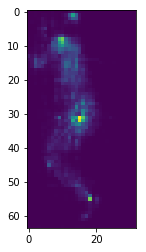

In [3]:
import matplotlib.pyplot as plt

plt.imshow(test_read[6,:].reshape(64,32))

Somehow, the first two recordings are weird in all subjects, so we will ignore them.

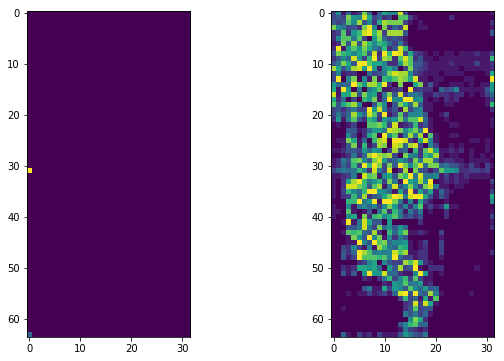

In [4]:

fig, axes = plt.subplots(figsize=(10,6), ncols=2)
for ii in range(2):
    ax = axes[ii]
    ax.imshow(test_read[ii,:].reshape(64,32))


Data Creation

	Data is collected using Vista Medical FSA SoftFlex 2048
2.	Size of pressure mat is 32*64. This is the raw data collected reporting numbers in range of [0-1000] for each sensor.
3.	Sampling rate is 1Hz.
4.	Each file includes the data frames around 2-mins (around 120 frames).


In [0]:
import torch

path_exp_1 = "/content/drive/My Drive//Raw_Data/experiment-i/"
positions = ["justAPlaceholder","supine", "right", "left", "right", "right", "left", "left", "supine", "supine", "supine", "supine", "supine", "right", "left", "supine", "supine", "supine"]

subjects_dict = {}

for _, dirs, _ in os.walk(path_exp_1):
  for directory in dirs:
    # each directory is a subject
    subject = directory
    data = None
    labels = None
    
    for _, _, files in os.walk(os.path.join(path_exp_1, directory)):
      for file in files:
        file_path = os.path.join(path_exp_1, directory, file)
        with open(file_path, 'r') as f:
          # Start from second recording, as the first two are corrupted
          for line in f.read().splitlines()[2:]:
            def token_position(x):
              return {
                'supine': 0,
                'left': 1,
                'right': 2,
                'left_fetus': 3,
                'right_fetus': 4
              }[x]
            
            
            raw_data = np.fromstring(line, dtype=float, sep='\t').reshape(1,64,32)
            file_data = np.round(raw_data*255/1000).astype(np.uint8) # Change the range from [0-1000] to [0-255]. This allows us to use tranforms later.
            file_label = token_position(positions[int(file[:-4])]) # Turn the file index into position list, and turn position list into reduced indices.
            file_label = np.array([file_label])
            
            if data is None:
              data = file_data
            else:
              data = np.concatenate((data, file_data), axis=0)

            if labels is None:
              labels = file_label
            else:
              labels = np.concatenate((labels, file_label), axis=0)
              
    subjects_dict[subject] = (torch.from_numpy(data), torch.from_numpy(labels))

In [0]:
from torch.utils.data import Dataset

class MattressExpOne(Dataset):
  def __init__(self, Subject_IDs):
    self.samples = np.vstack([subjects_dict.get(key)[0] for key in Subject_IDs])
    self.labels = np.hstack([subjects_dict.get(key)[1] for key in Subject_IDs])
    
  def __len__(self):
    return self.samples.shape[0]
      
  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

PyTorch gives you the freedom to pretty much do anything with the Dataset class so long as you override two of the subclass functions:

+ the __len__ function which returns the size of the dataset, and
+ the __getitem__ function which returns a sample from the dataset given an index.

In [0]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

data_exp_1 = MattressExpOne([key for key in subjects_dict.keys()])

trainset_exp_1, valset_exp_1 = random_split(data_exp_1, [round(len(data_exp_1)*0.70), len(data_exp_1) - round(len(data_exp_1)*0.70)])

trainloader = DataLoader(trainset_exp_1, batch_size=64, shuffle=True)
testloader = DataLoader(valset_exp_1, batch_size=64, shuffle=False)

In [8]:
import torch
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Input channels = 1, output channels = 6
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(6, 18, kernel_size=3, stride=1, padding=1)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        # Inputs to hidden layer linear transformation
        self.h1 = nn.Linear(18 * 16 * 8, 392)
        self.h2 = nn.Linear(392, 98)
        
        # Output layer, 3 neurons - one for each position
        self.output = nn.Linear(98, 5)
        
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.float()
        # Add a "channel dimension"
        x = x.unsqueeze(1)
        
        #Computes the activation of the first convolution
        #Size changes from (1, 64, 32) to (6, 64, 32)
        
        x = F.relu(self.conv1(x))

        
        #Size changes from (6, 32, 16) to (6, 32, 16)
        x = self.pool(x)

        
        #Size changes from (6, 32, 16) to (18, 32, 16)
        x = F.relu(self.conv2(x))

        
        #Size changes from (18, 32, 16) to (18, 16, 8)
        x = self.pool(x)
        


        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        
        x = x.view(x.shape[0], -1)
        # Pass the input tensor through each of our operations
        x = self.h1(x)

        x = self.relu(x)
        x = self.h2(x)

        x = self.relu(x)
        x = self.output(x)

        x = self.logsoftmax(x)
        
        return x
      
model = Network()
model

Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=5, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
from torch import optim

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.01)

model.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=5, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

Epoch 1/15.. Train loss: 0.563.. Test loss: 0.003.. Test accuracy: 0.999
Epoch 2/15.. Train loss: 0.004.. Test loss: 0.005.. Test accuracy: 0.999
Epoch 3/15.. Train loss: 0.020.. Test loss: 0.127.. Test accuracy: 0.976
Epoch 4/15.. Train loss: 0.042.. Test loss: 0.057.. Test accuracy: 0.996
Epoch 5/15.. Train loss: 0.002.. Test loss: 0.005.. Test accuracy: 1.000
Epoch 6/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 7/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 8/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 9/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 10/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 11/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 12/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 13/15.. Train loss: 0.000.. Test loss: 0.009.. Test accuracy: 0.999
Epoch 14/15.. Train loss: 0.000.. Test loss: 0.

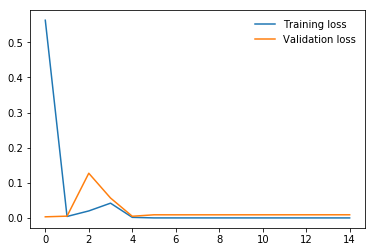

In [11]:
epochs = 15
running_loss = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
  for inputs, labels in trainloader:
  
    inputs, labels = inputs.to(device), labels.to(device)
  
    optimizer.zero_grad()

    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  else:
    
    test_loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        test_loss += criterion(logps, labels)
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
        
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(trainloader):.3f}.. "
          f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")
    running_loss = 0
    model.train()
    
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


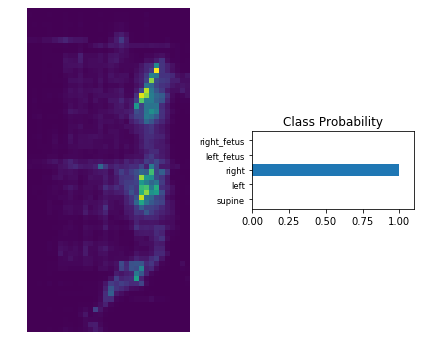

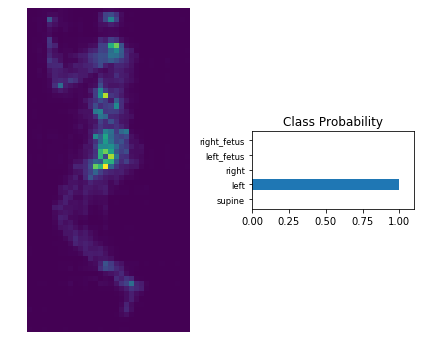

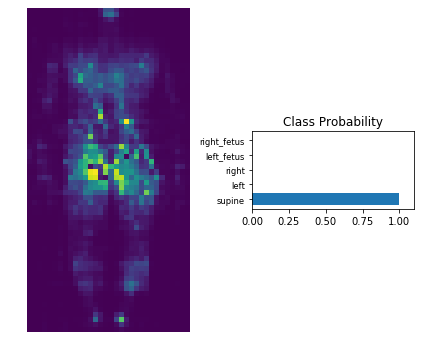

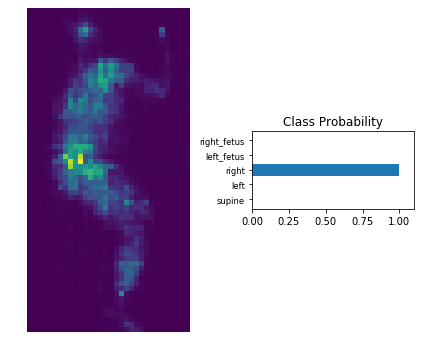

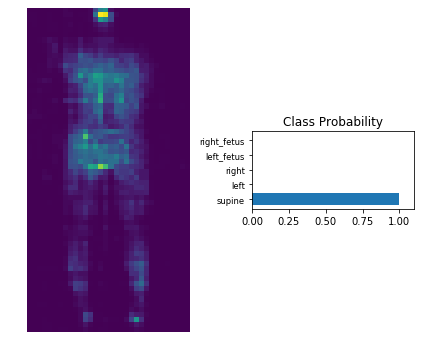

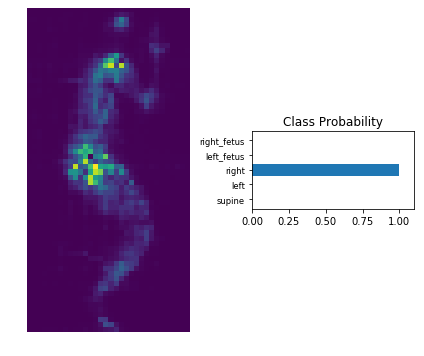

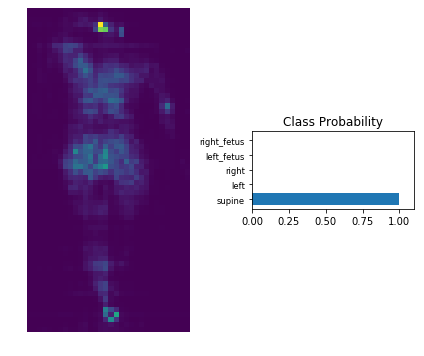

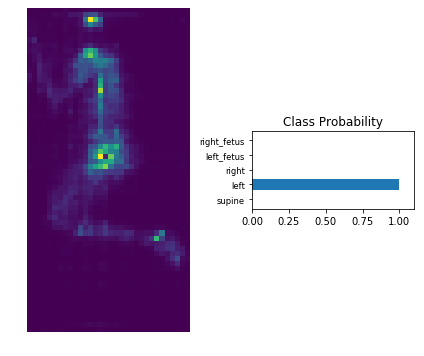

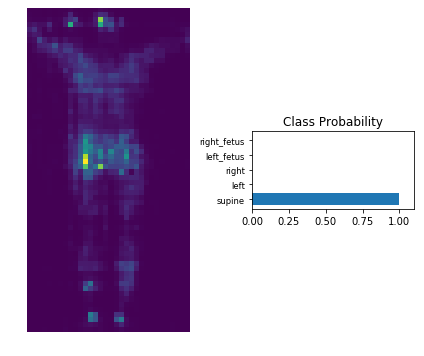

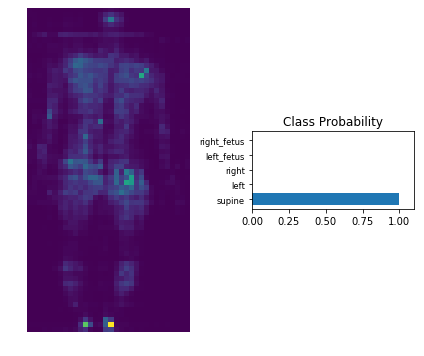

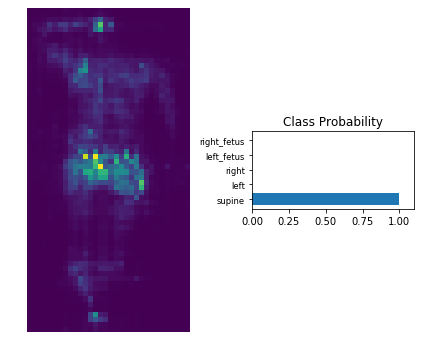

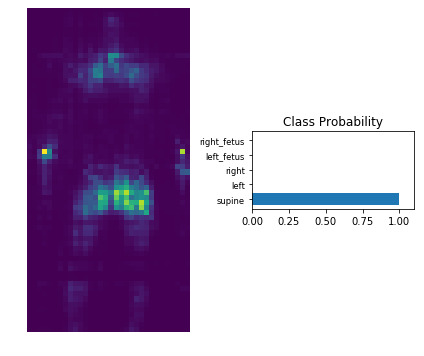

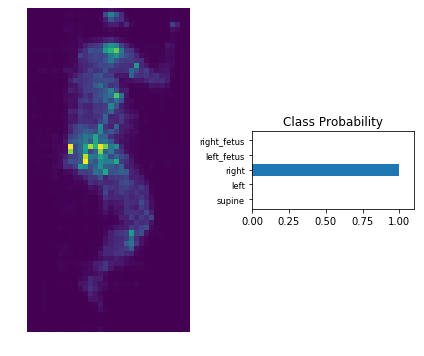

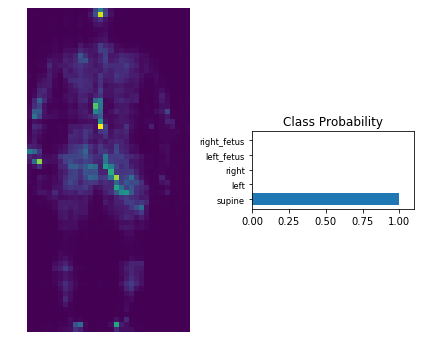

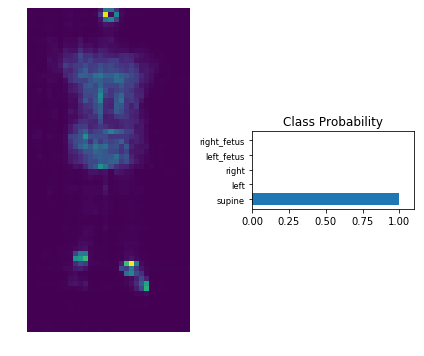

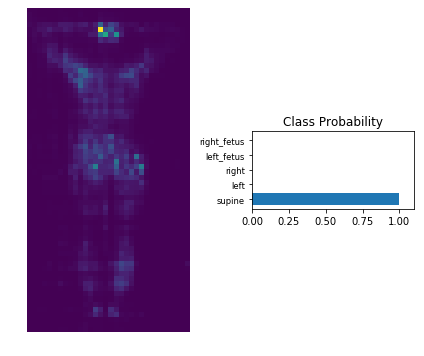

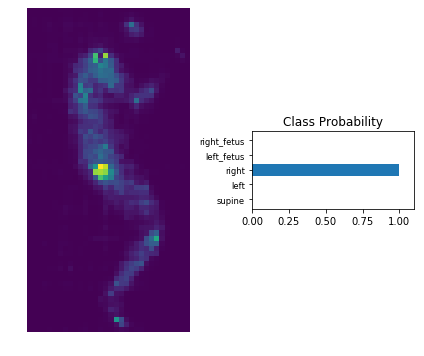

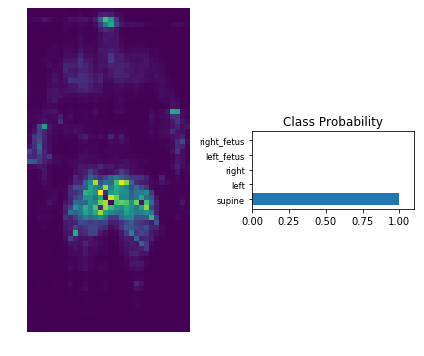

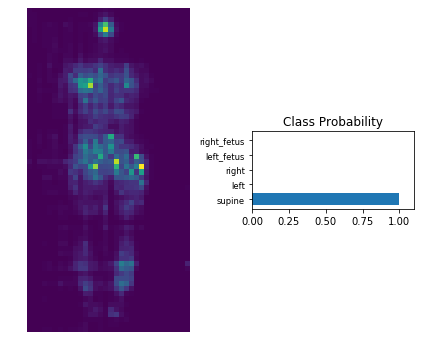

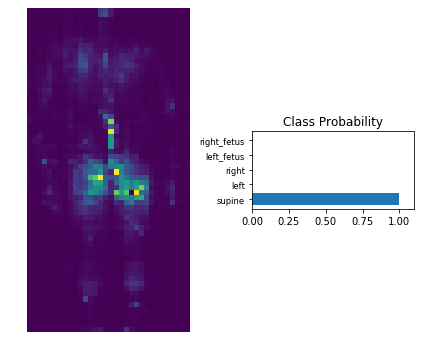

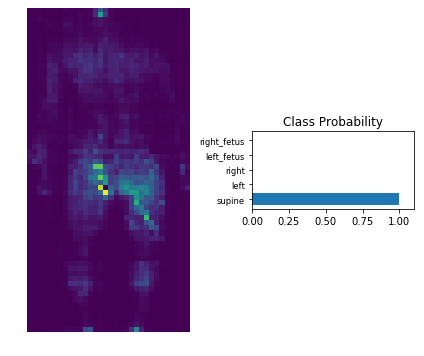

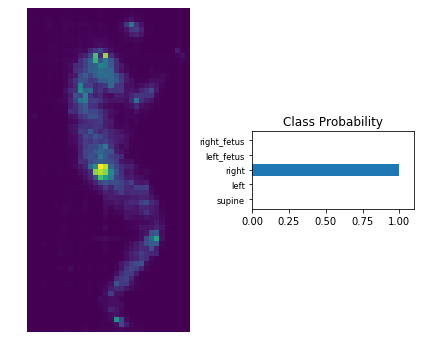

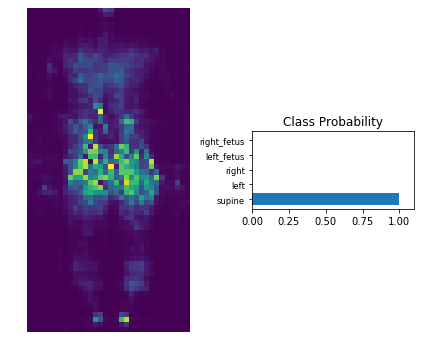

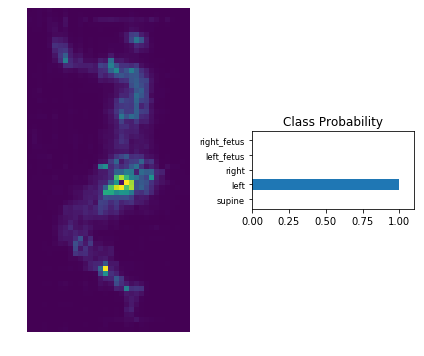

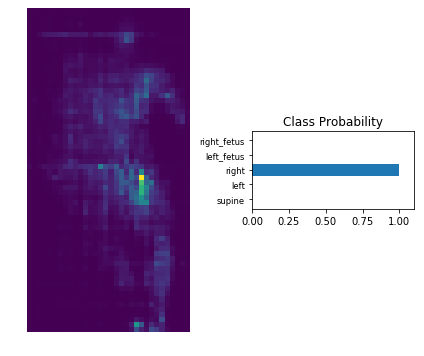

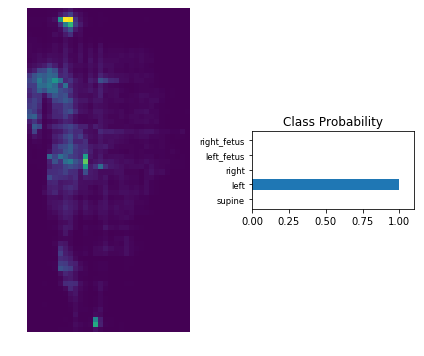

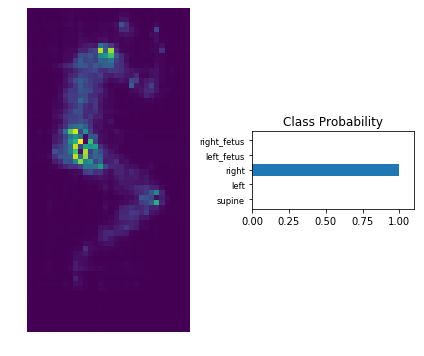

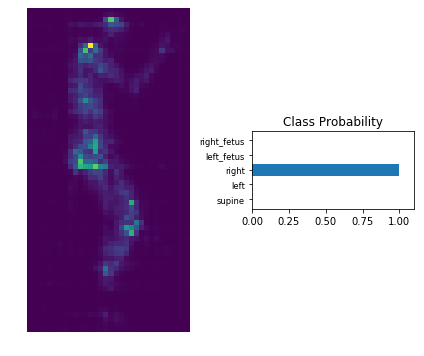

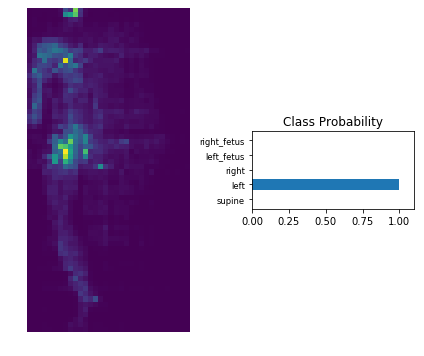

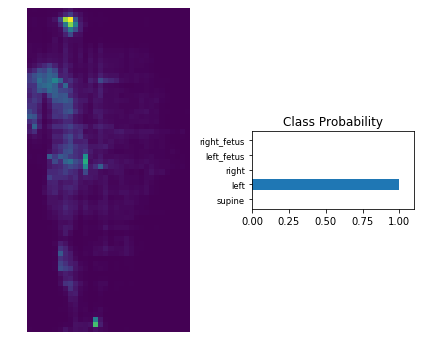

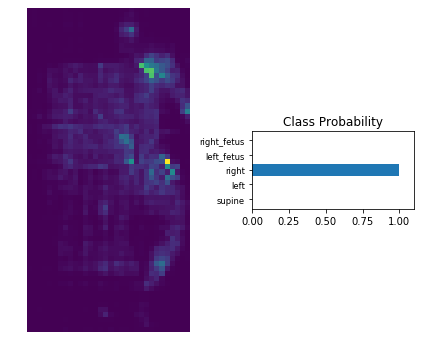

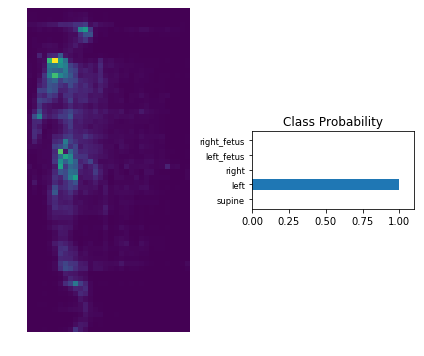

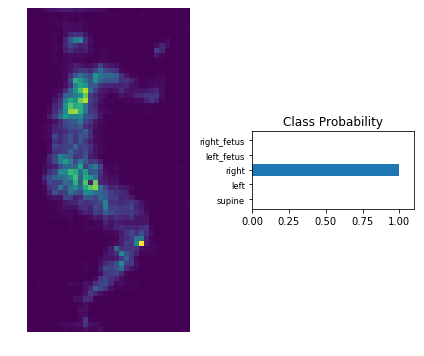

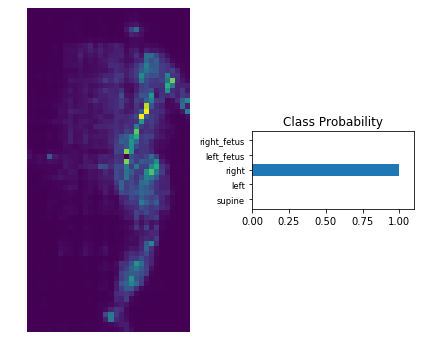

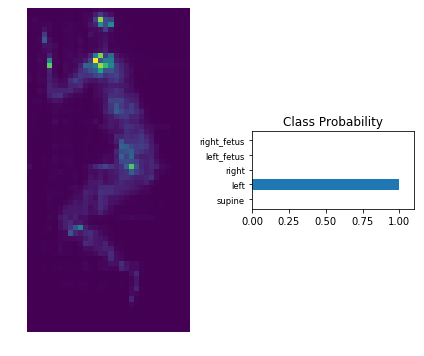

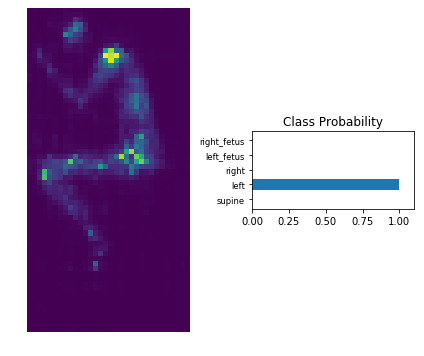

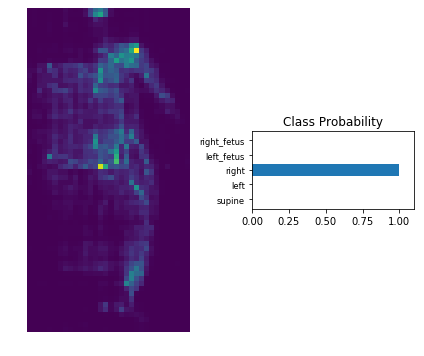

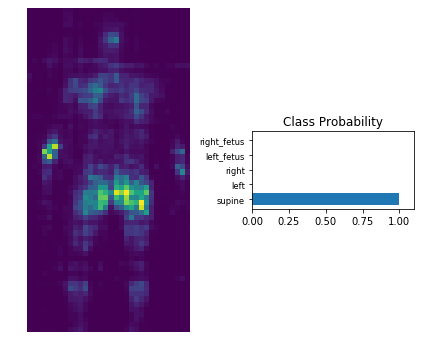

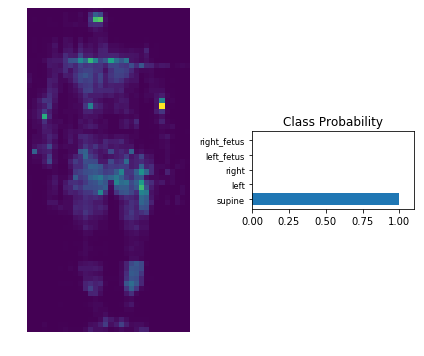

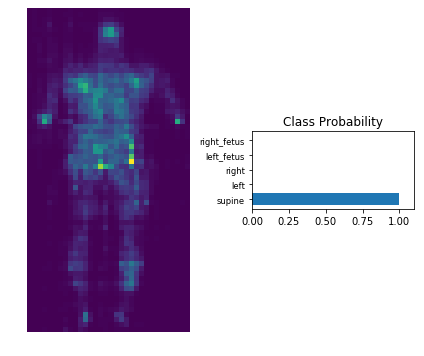

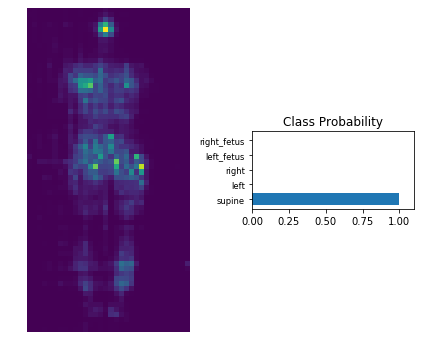

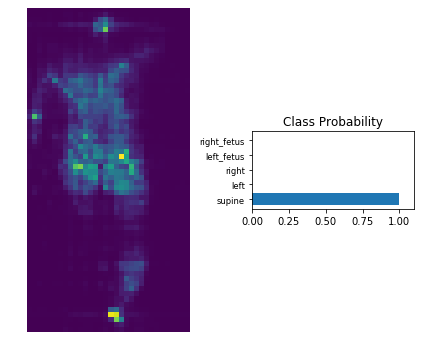

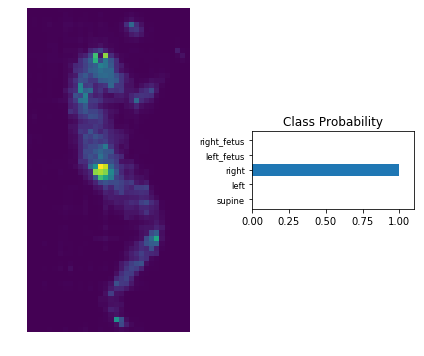

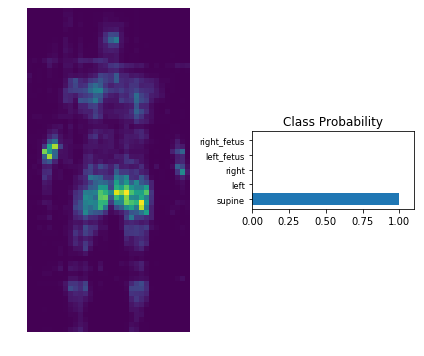

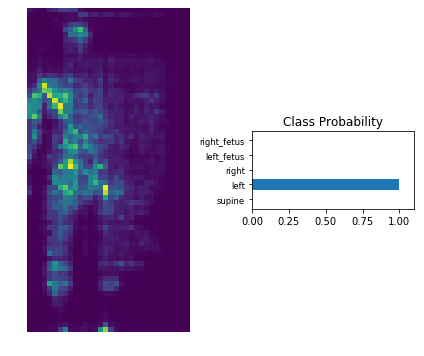

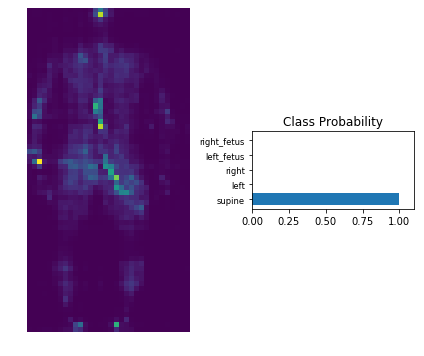

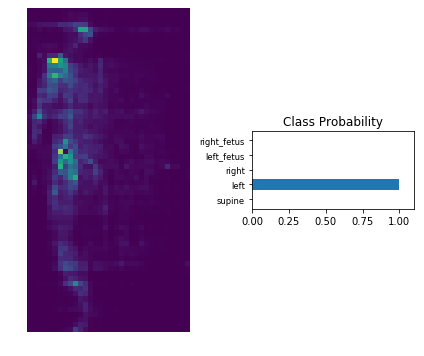

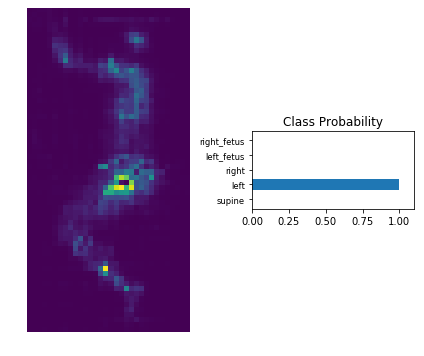

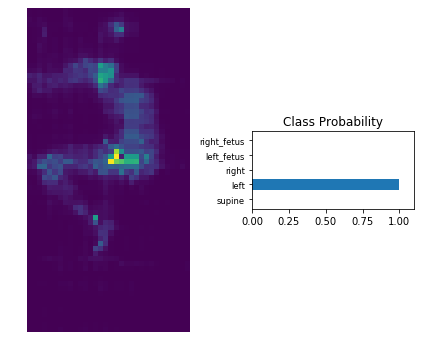

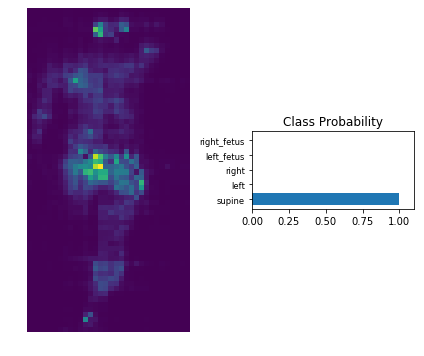

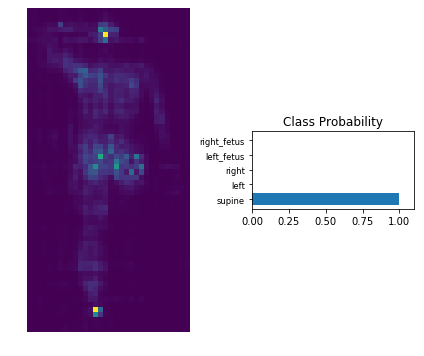

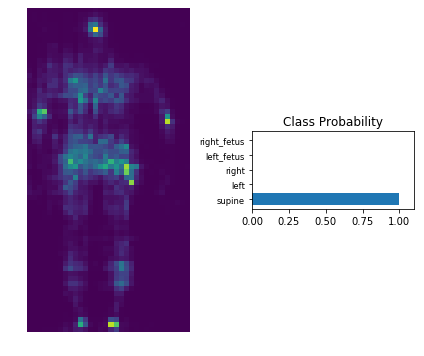

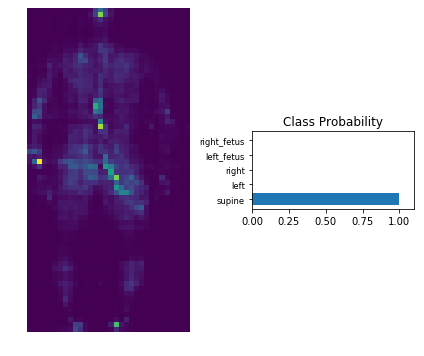

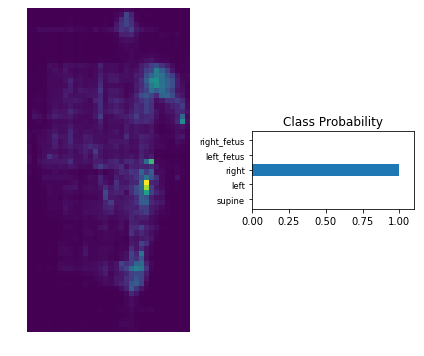

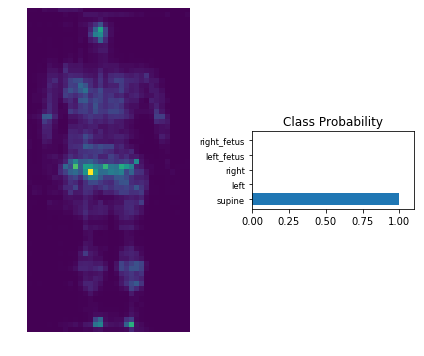

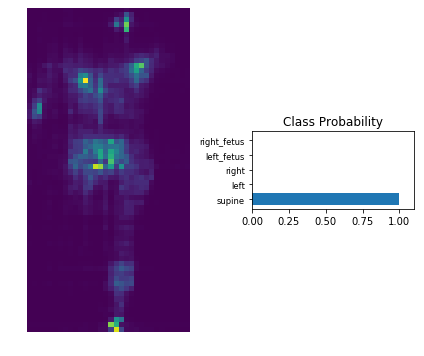

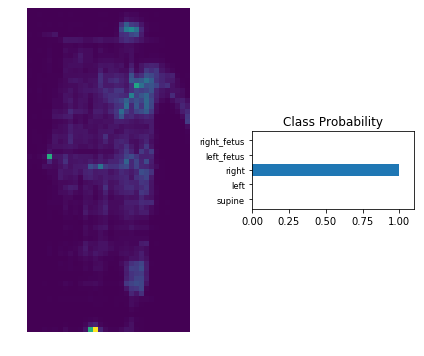

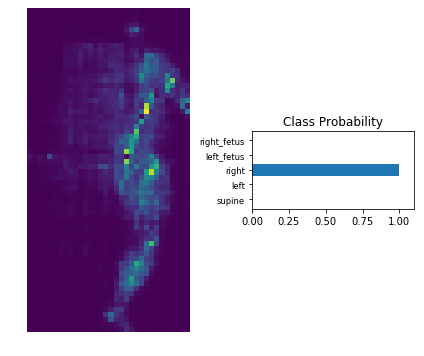

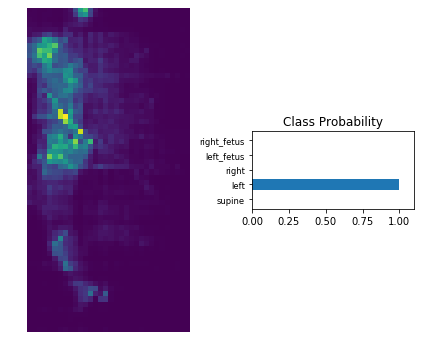

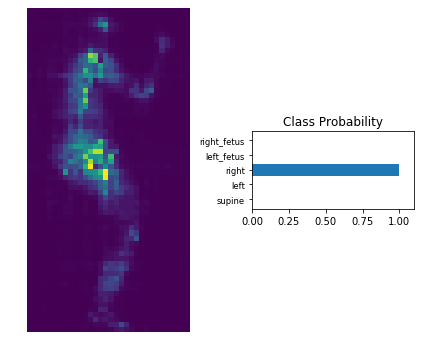

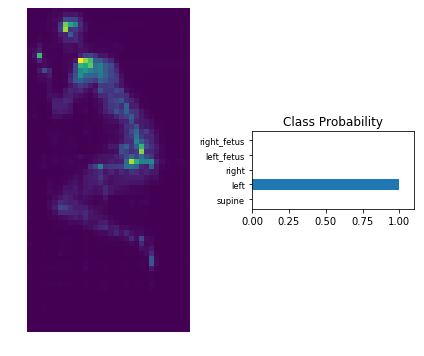

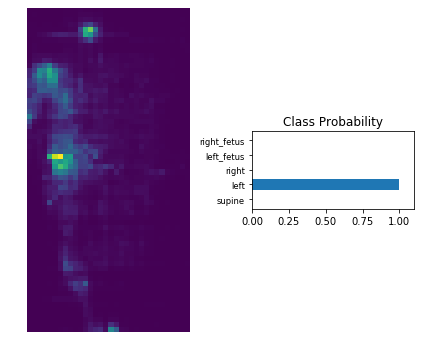

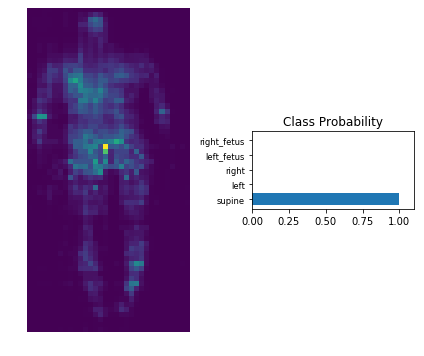

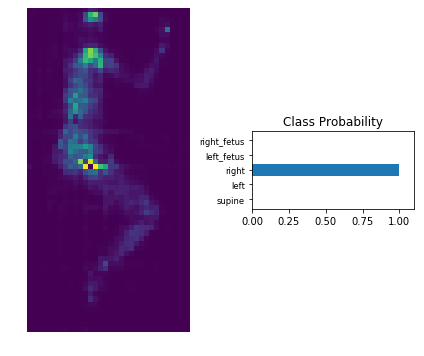

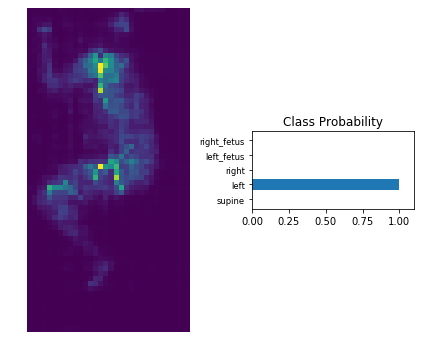

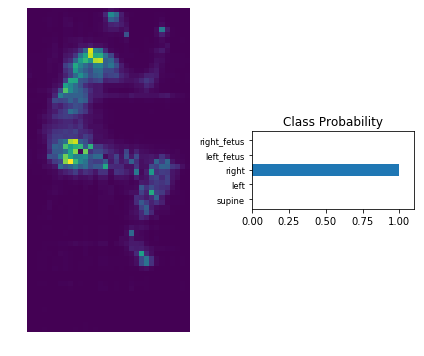

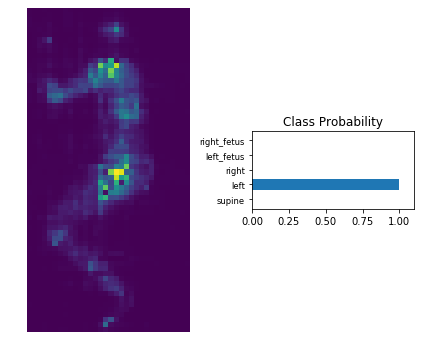

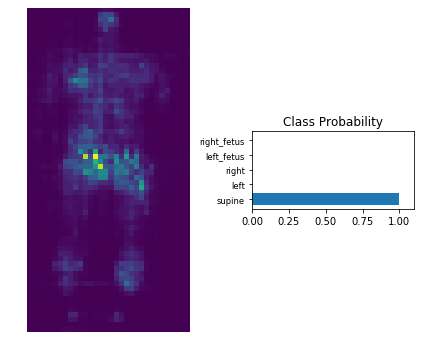

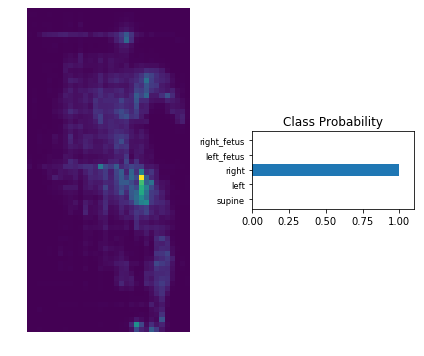

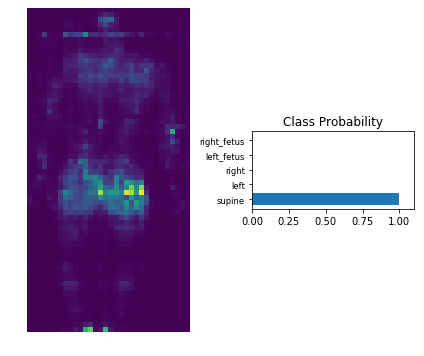

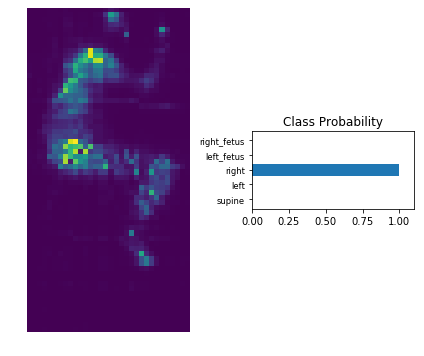

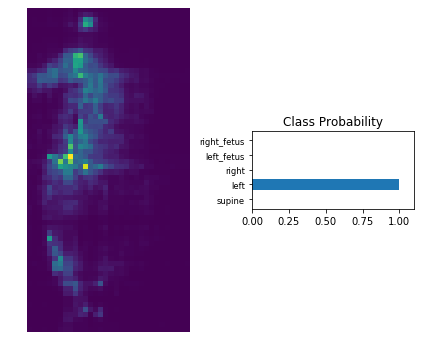

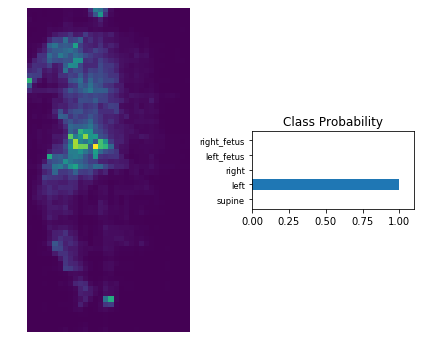

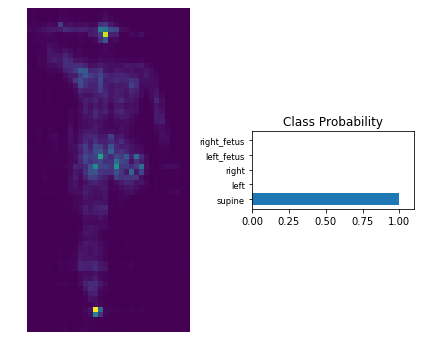

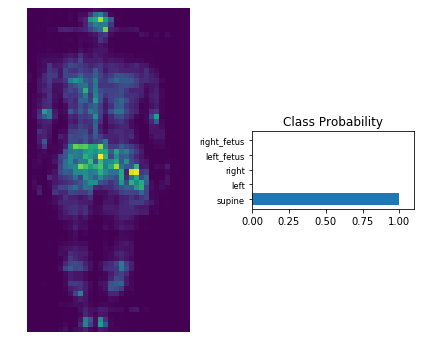

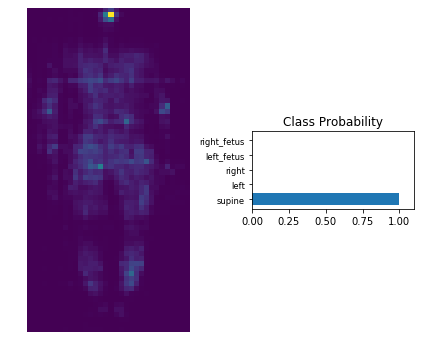

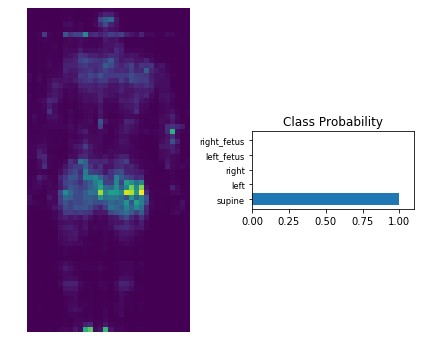

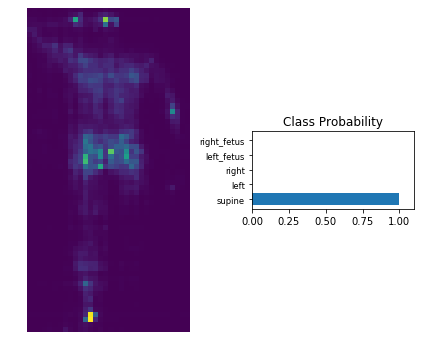

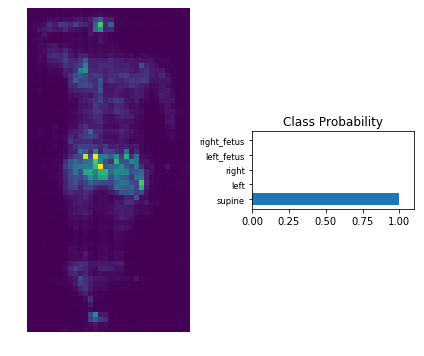

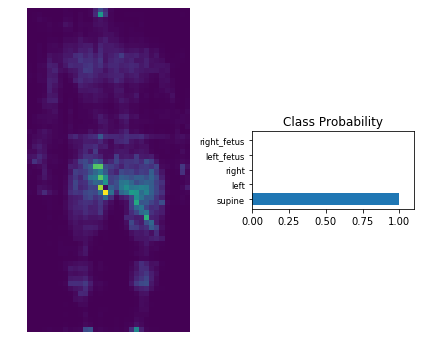

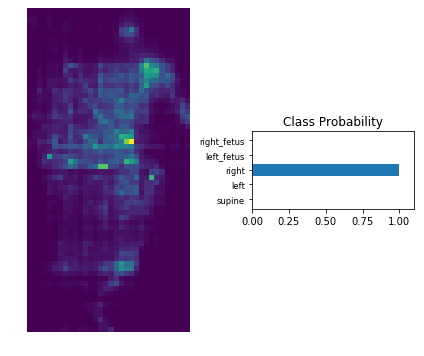

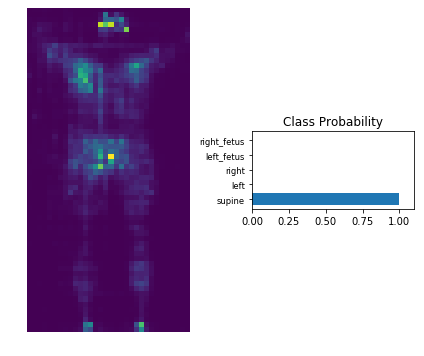

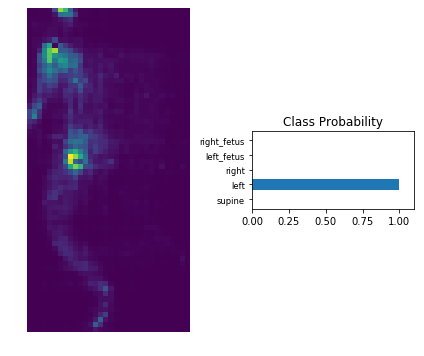

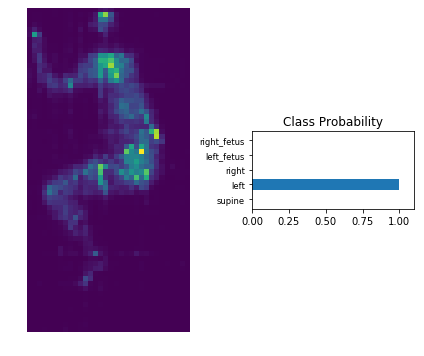

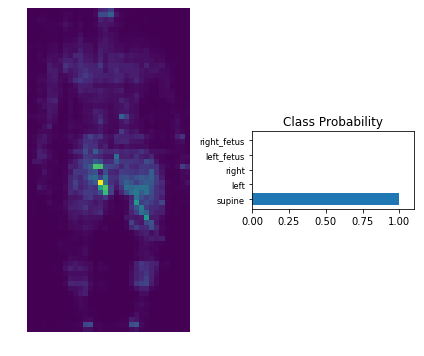

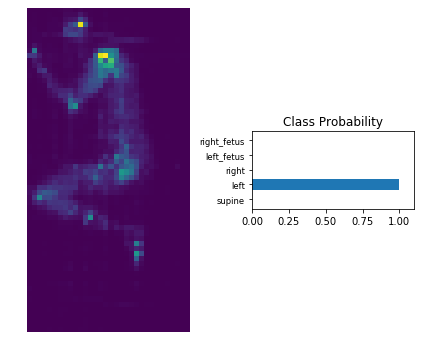

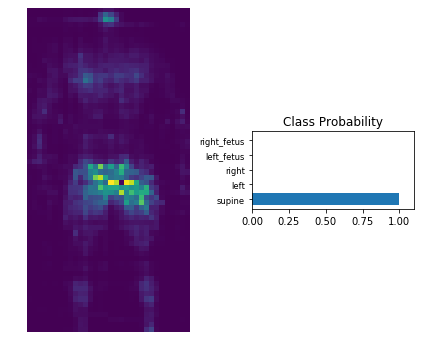

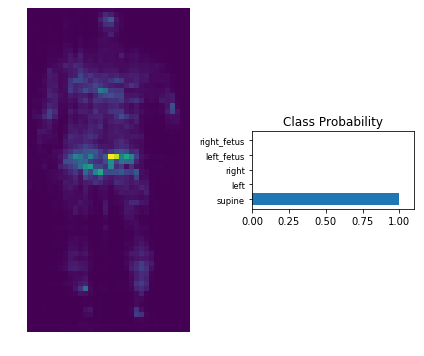

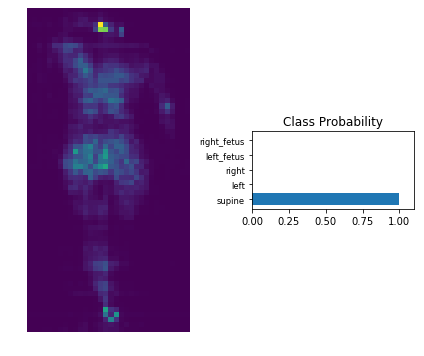

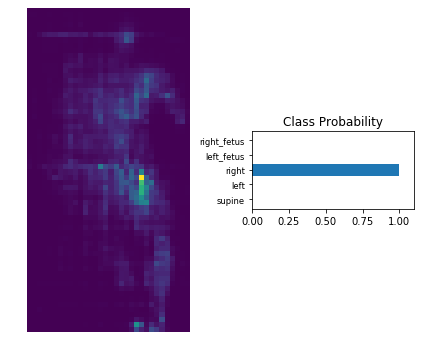

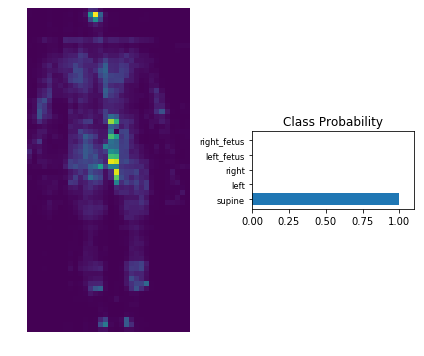

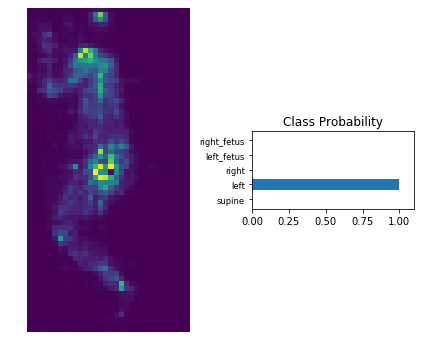

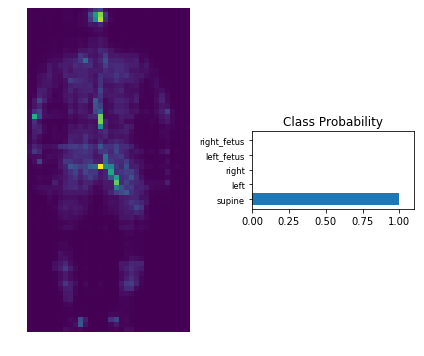

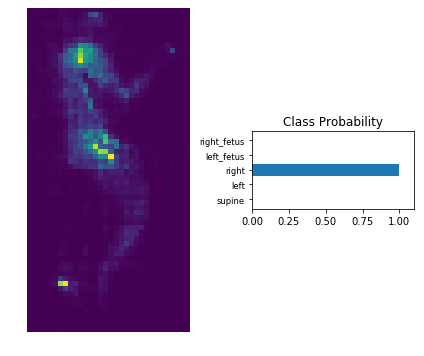

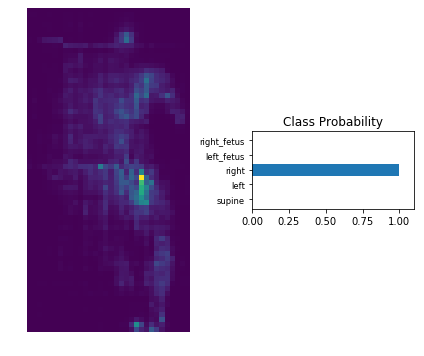

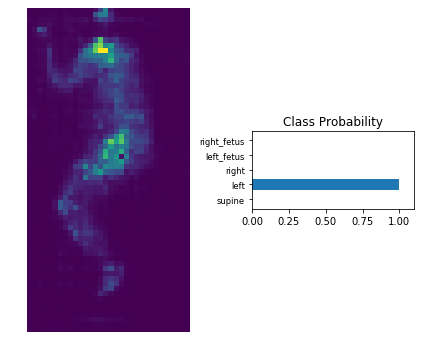

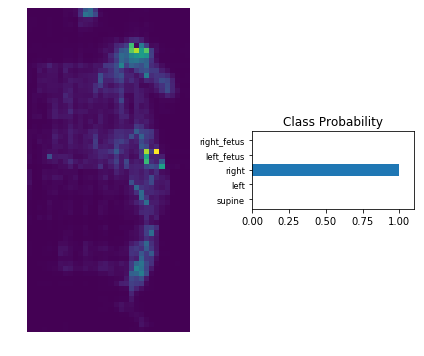

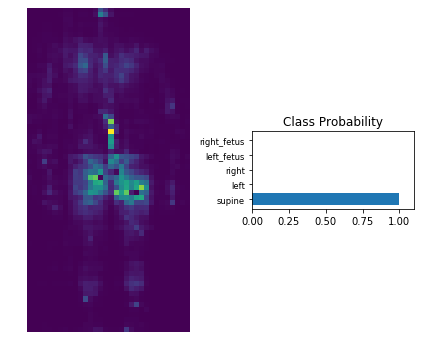

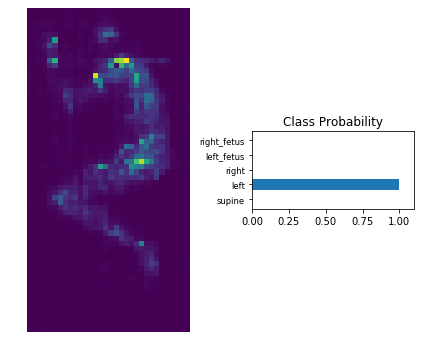

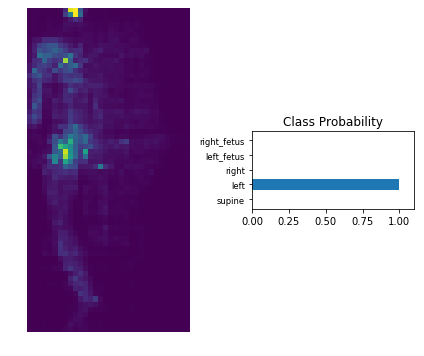

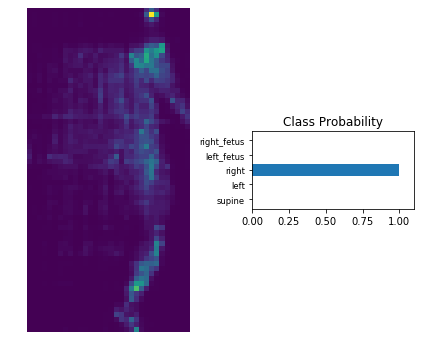

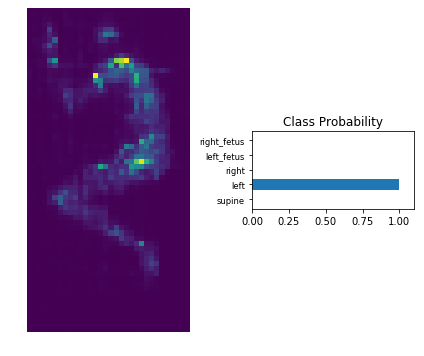

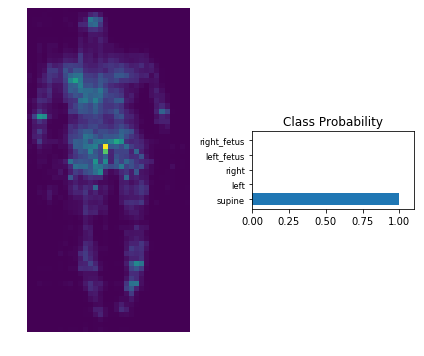

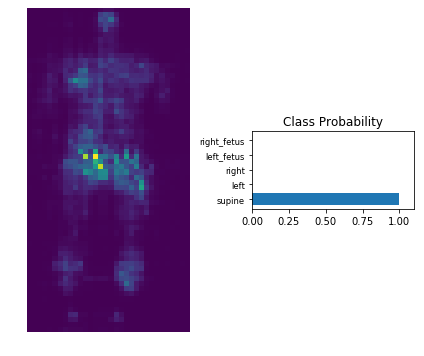

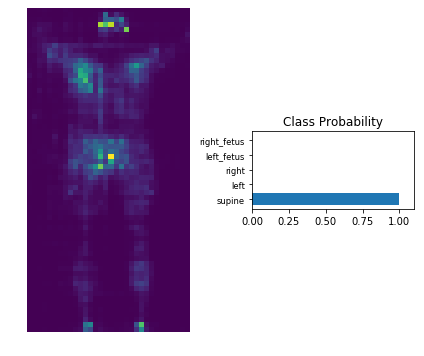

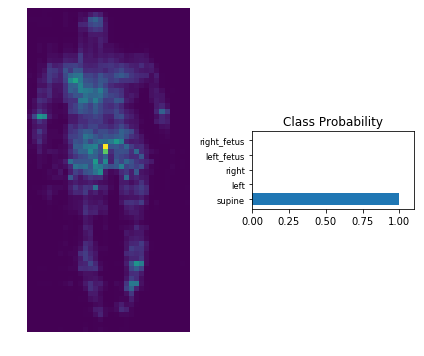

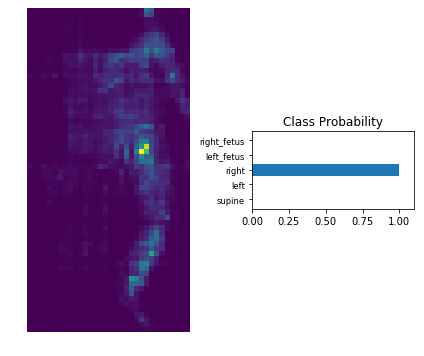

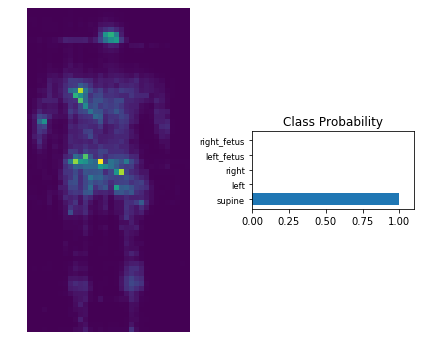

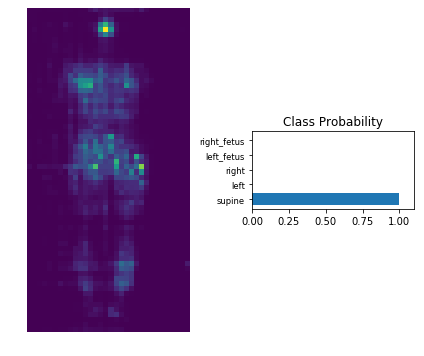

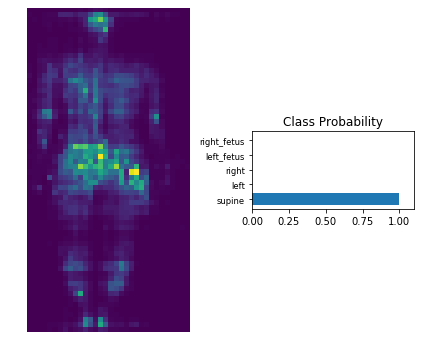

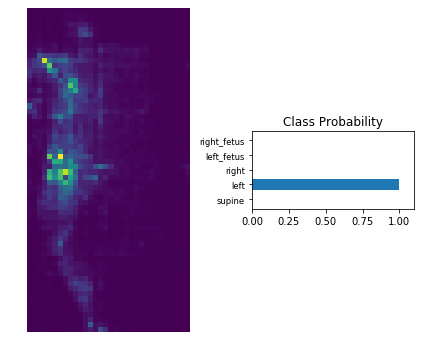

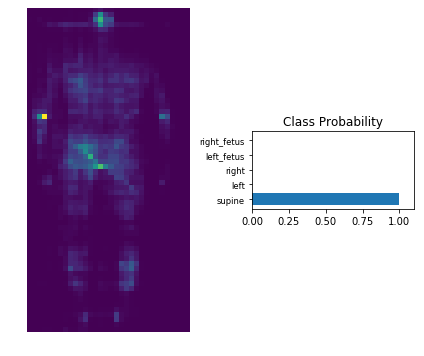

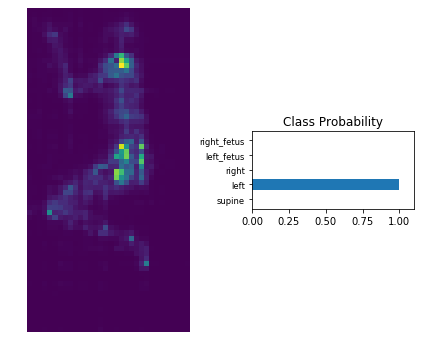

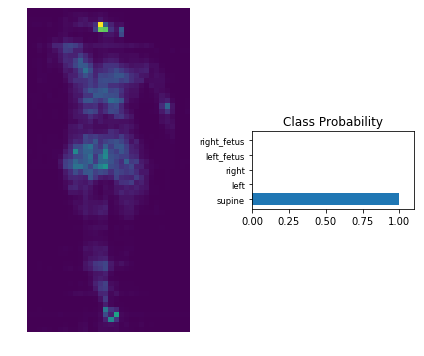

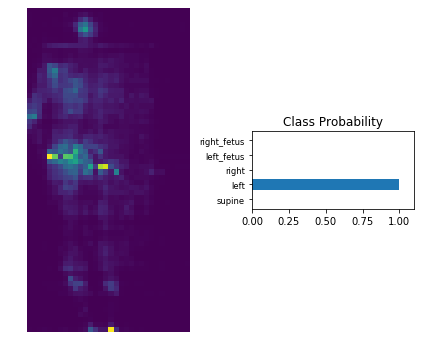

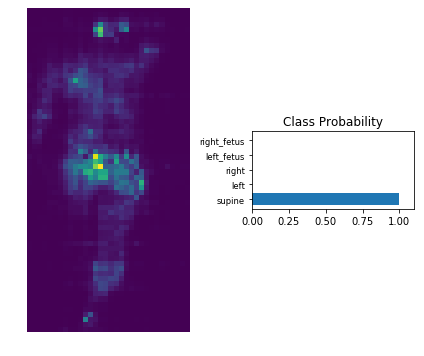

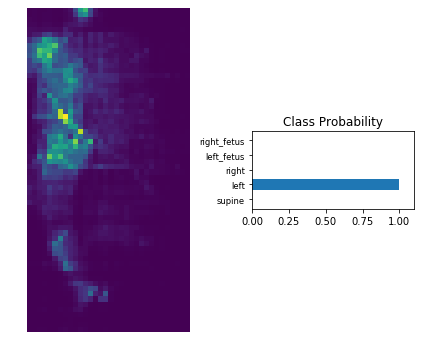

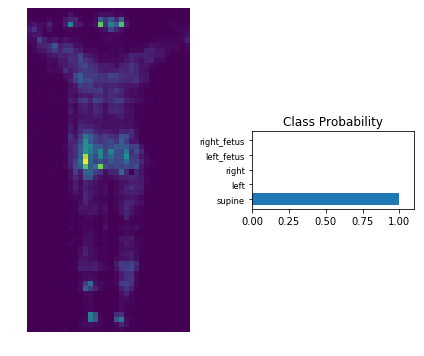

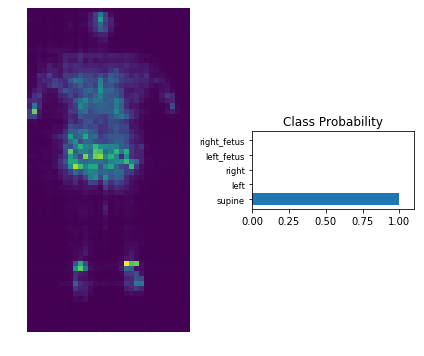

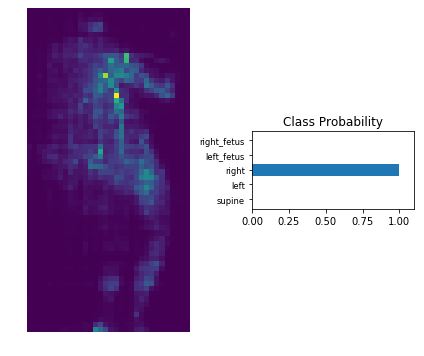

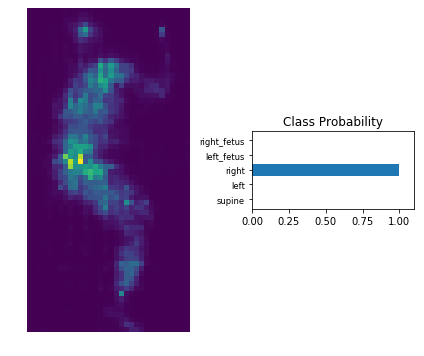

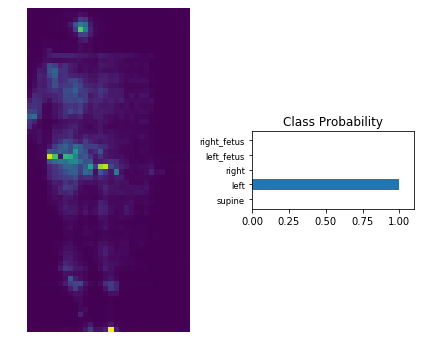

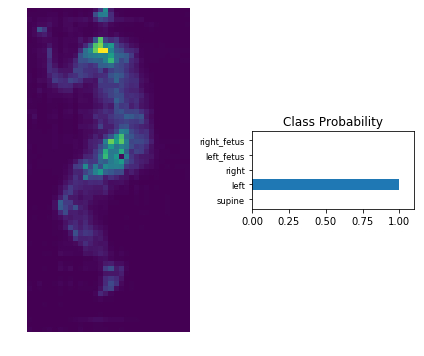

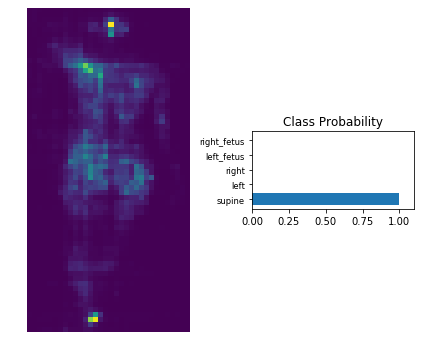

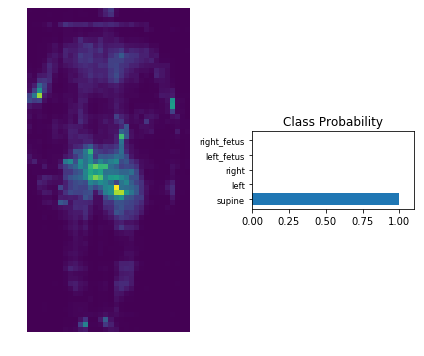

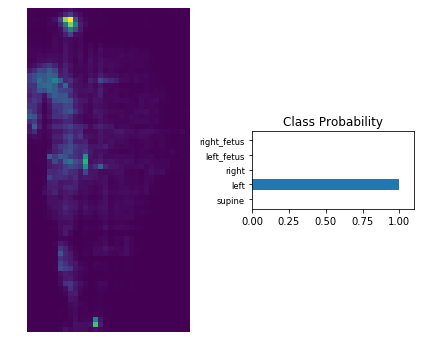

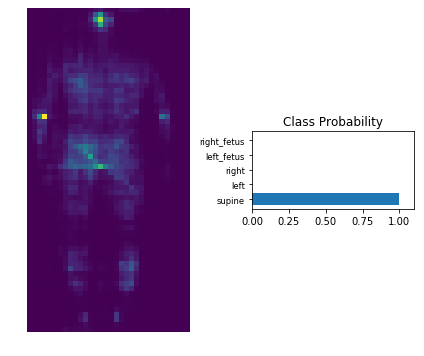

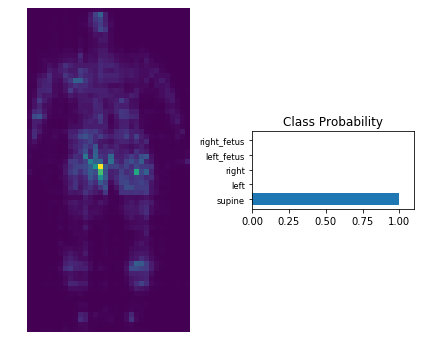

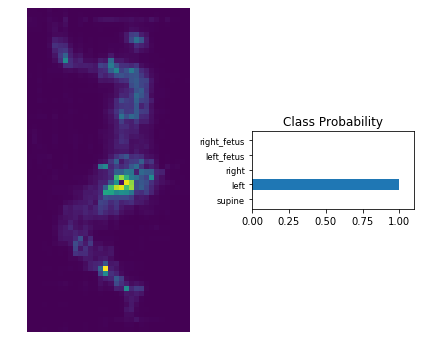

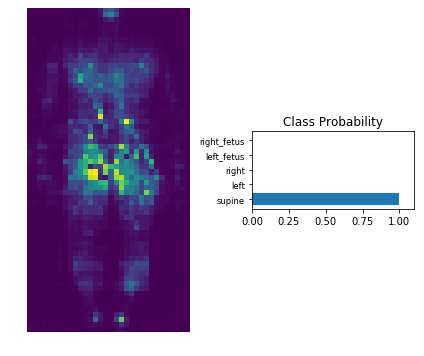

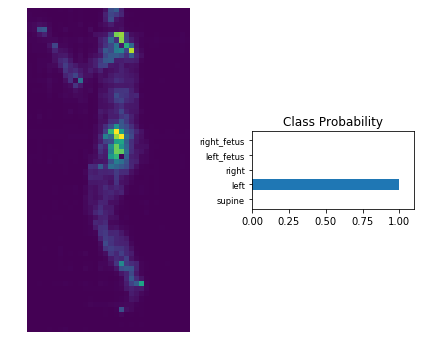

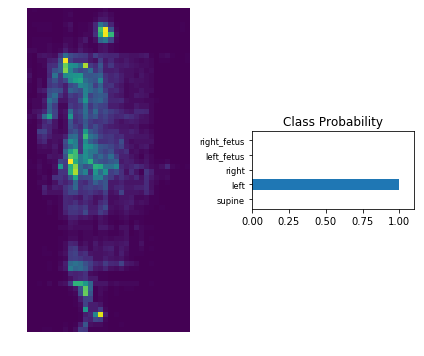

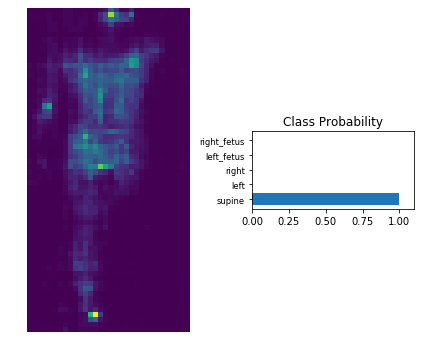

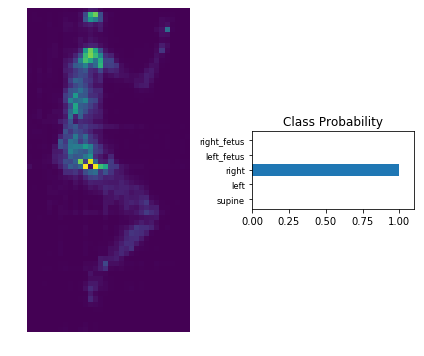

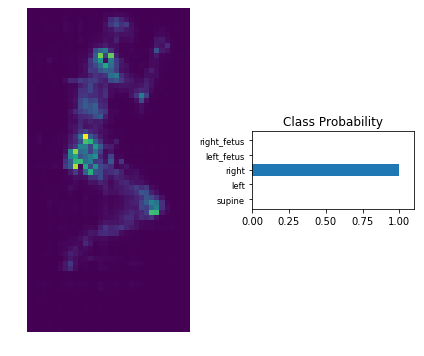

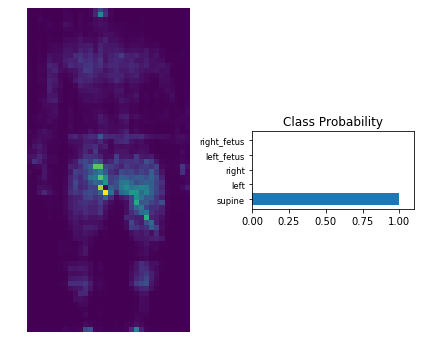

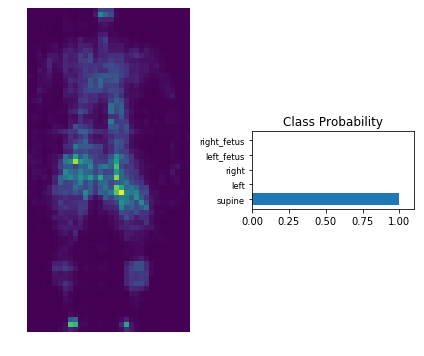

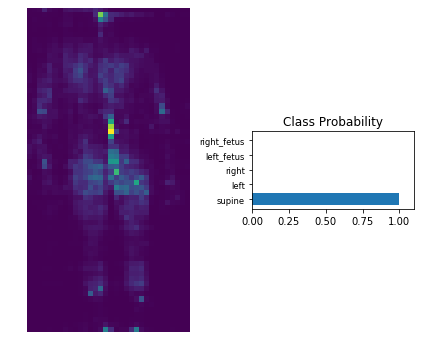

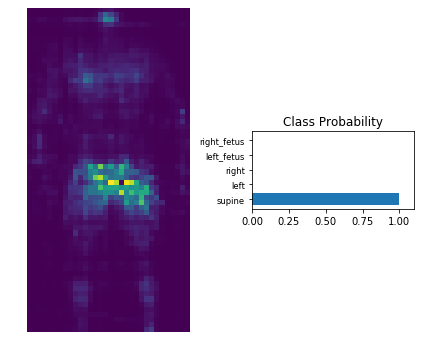

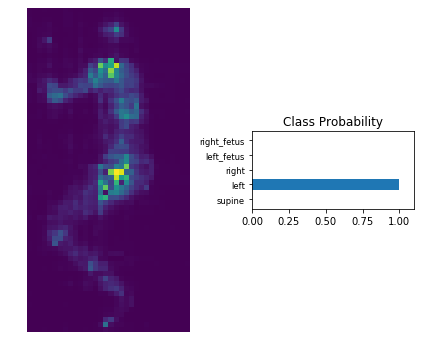

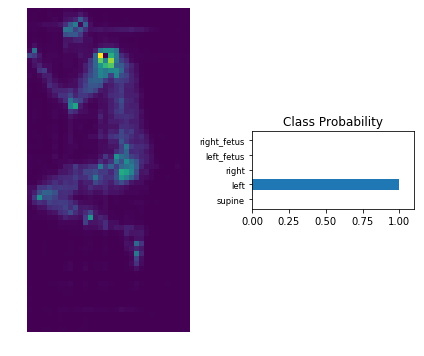

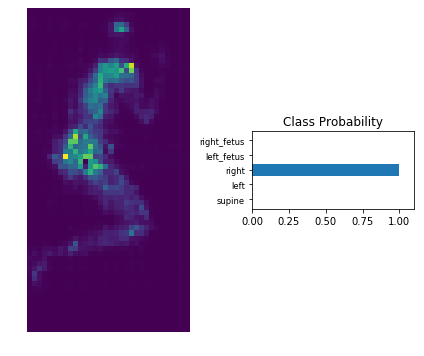

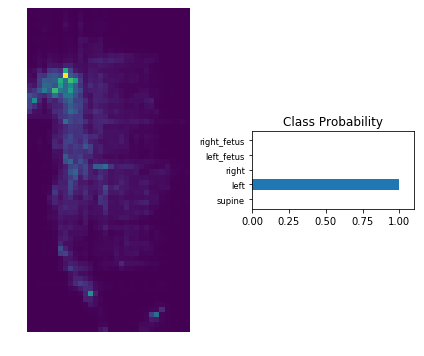

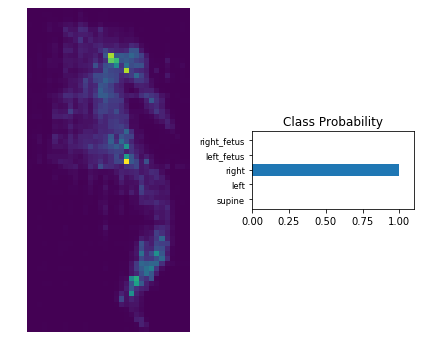

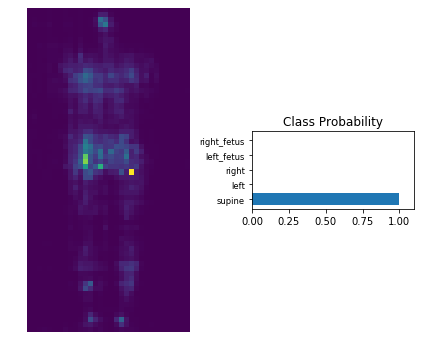

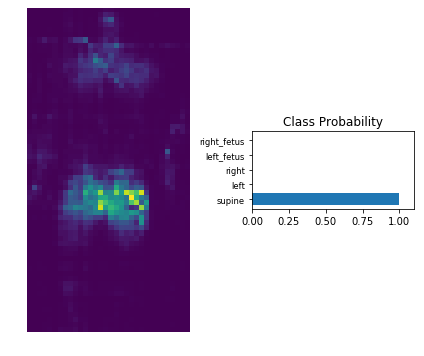

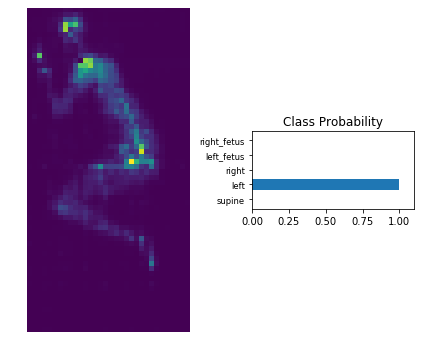

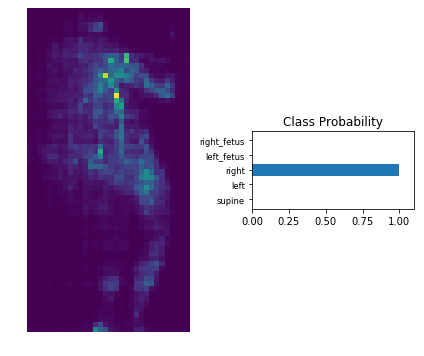

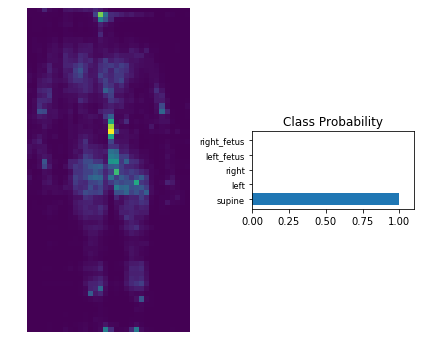

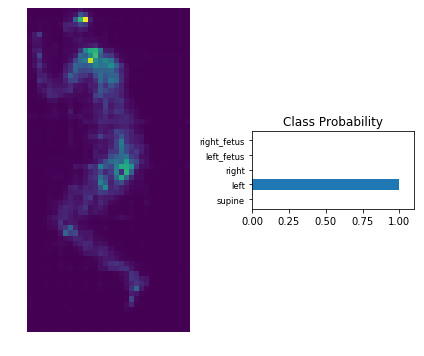

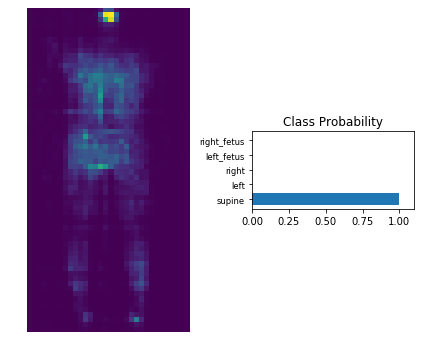

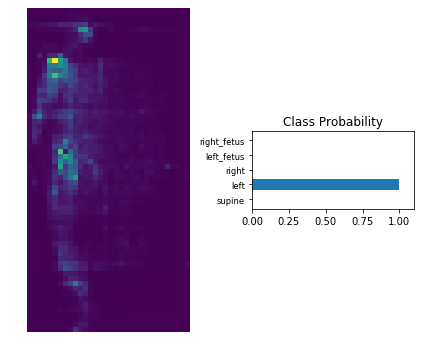

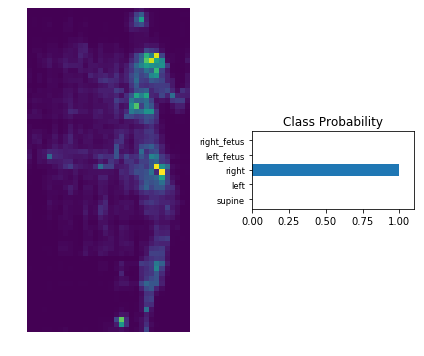

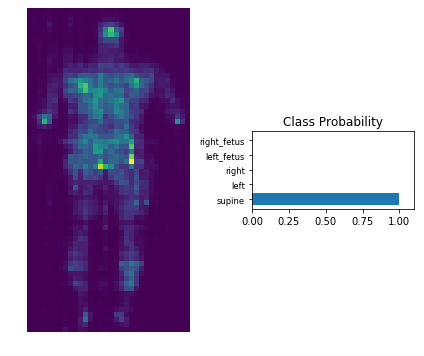

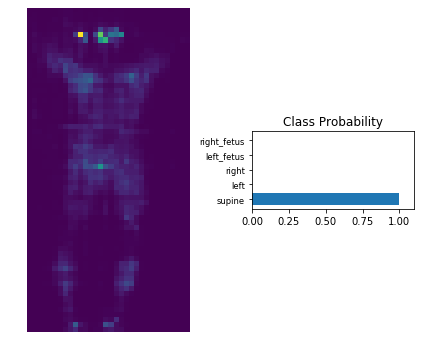

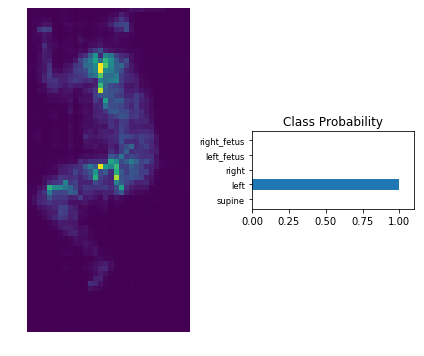

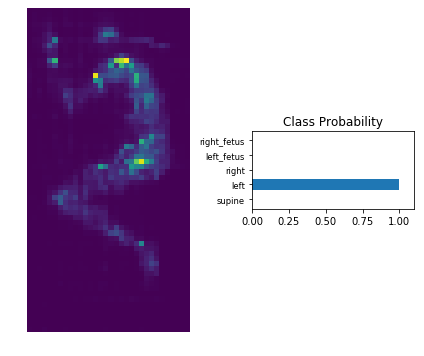

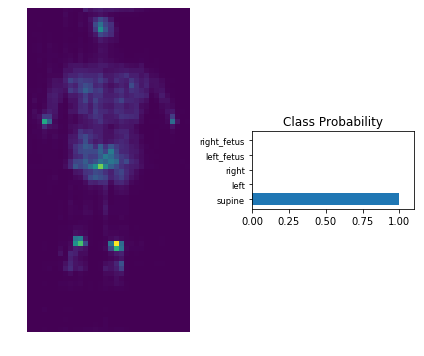

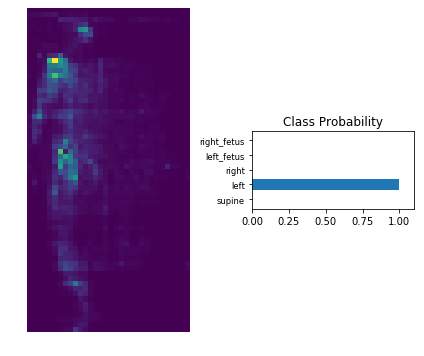

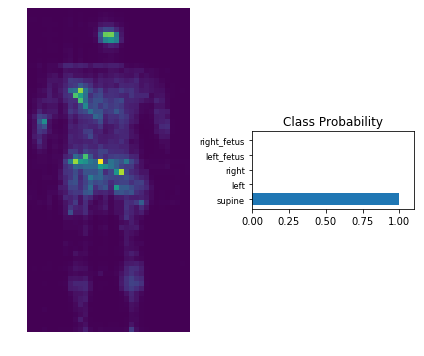

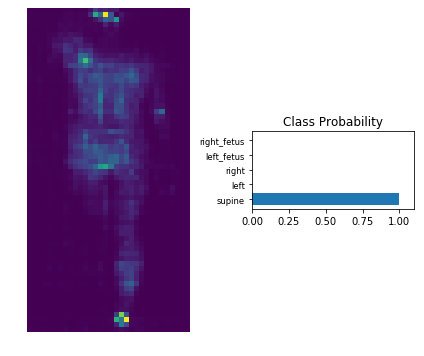

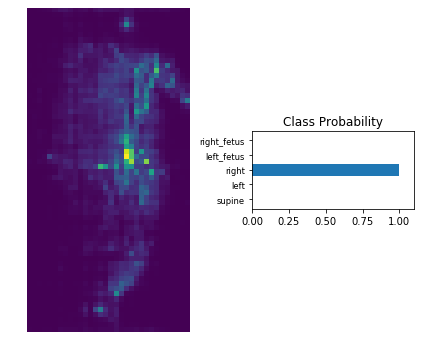

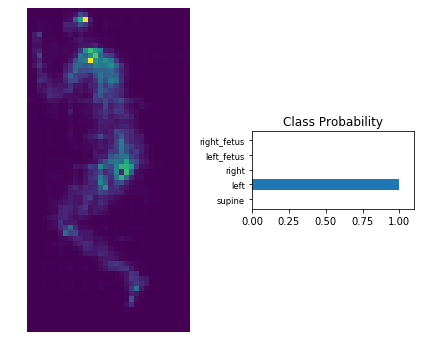

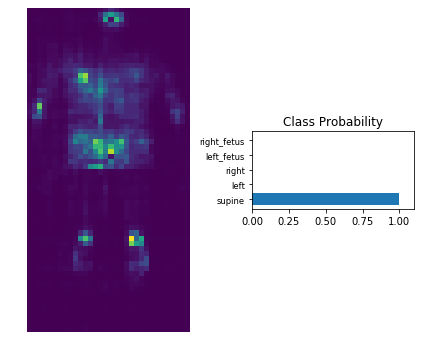

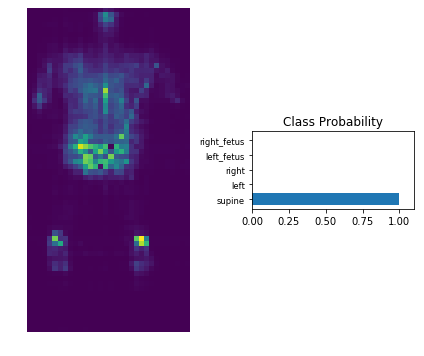

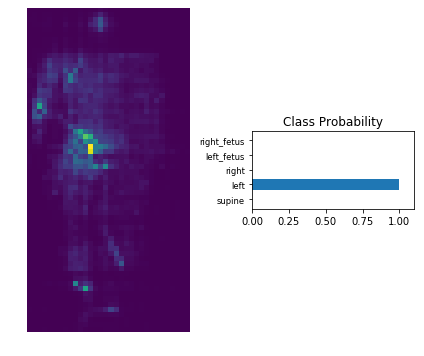

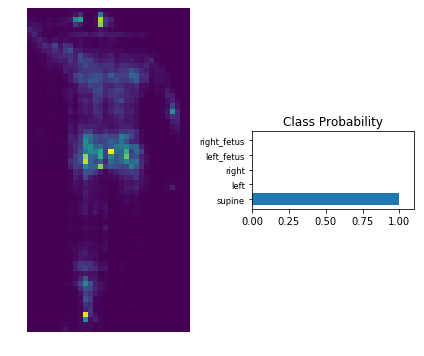

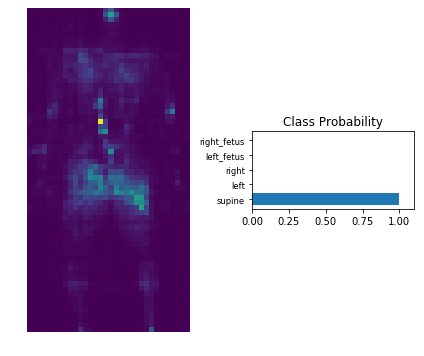

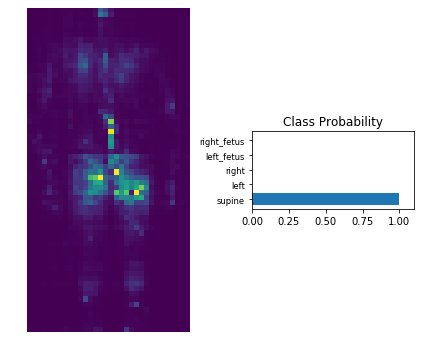

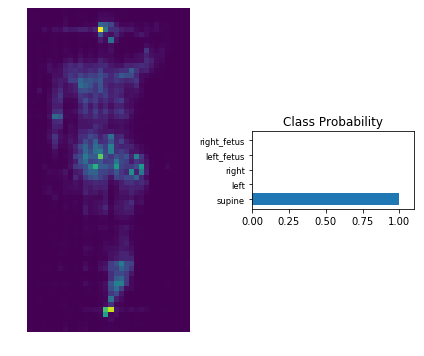

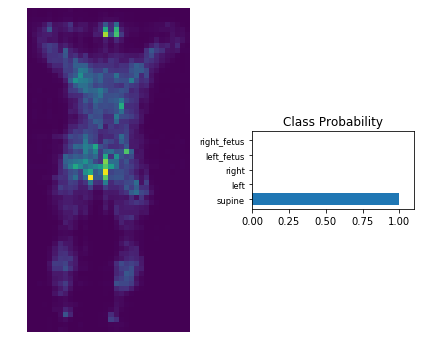

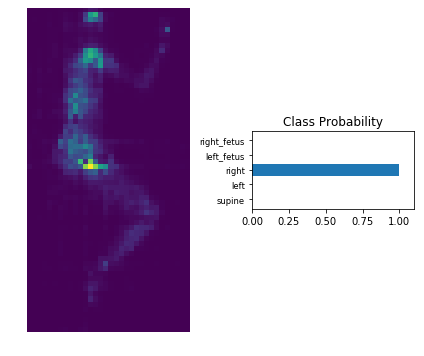

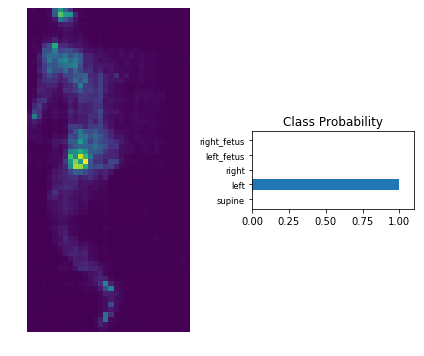

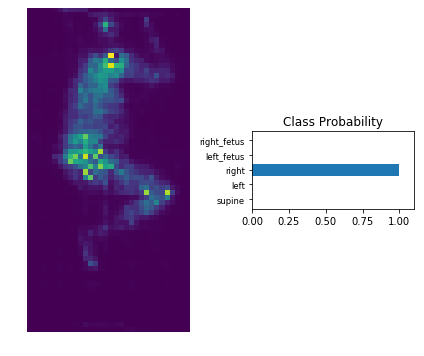

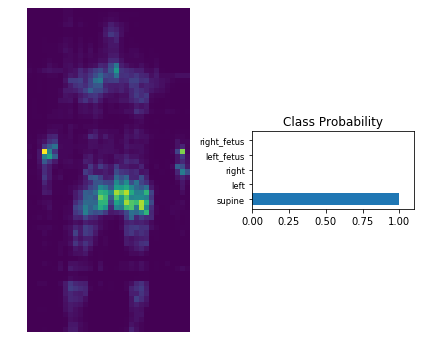

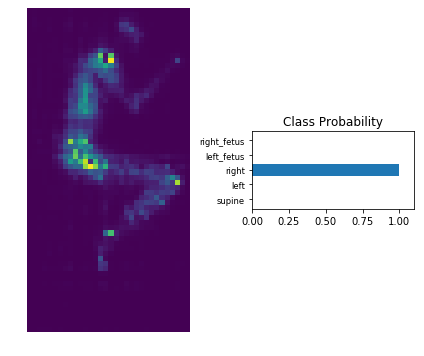

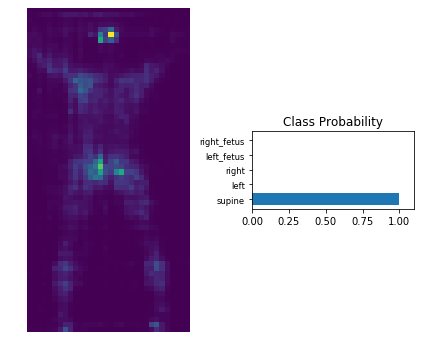

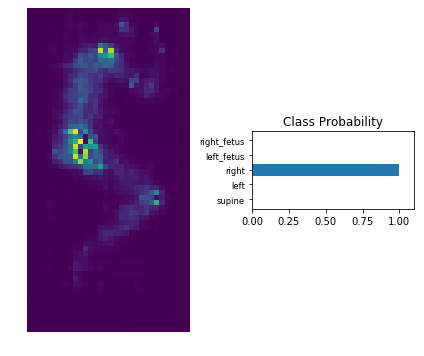

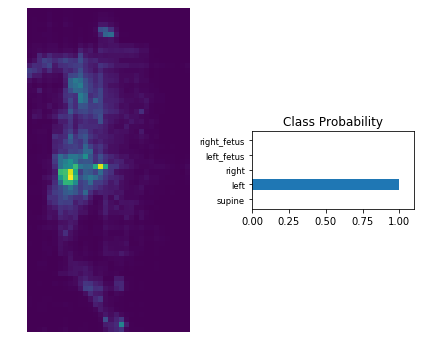

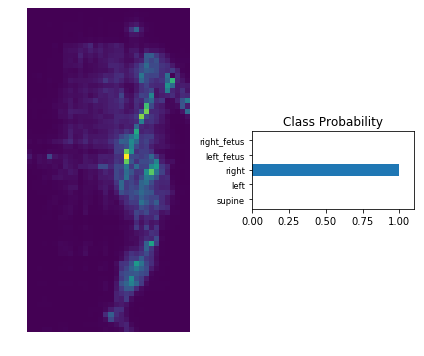

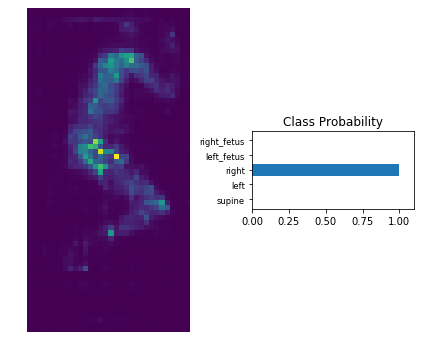

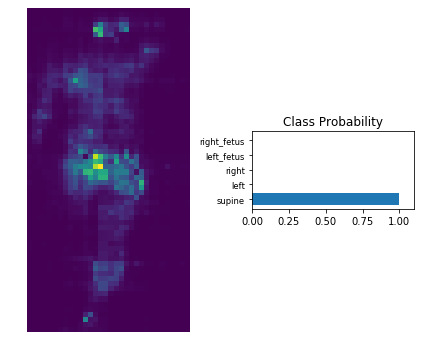

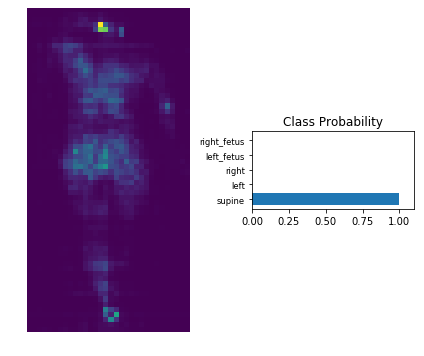

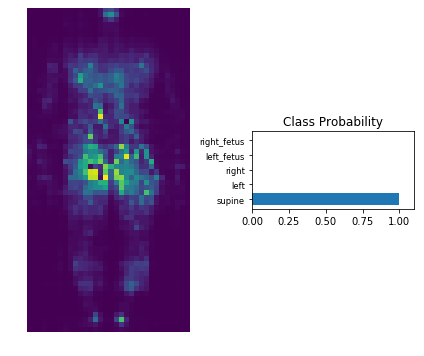

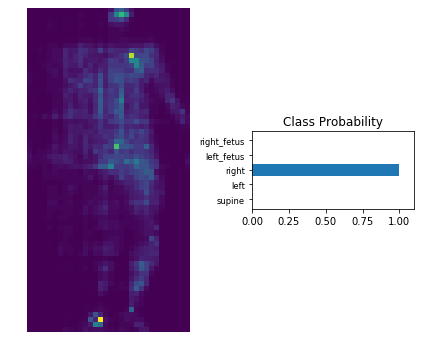

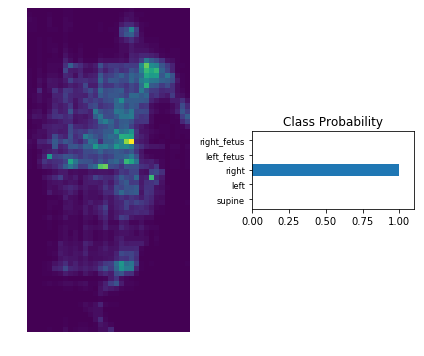

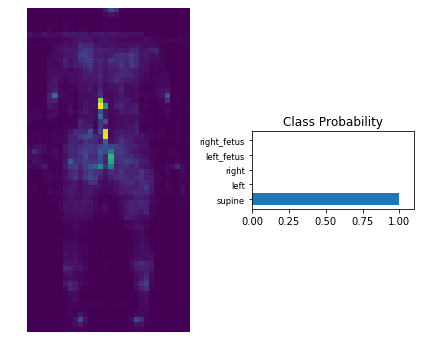

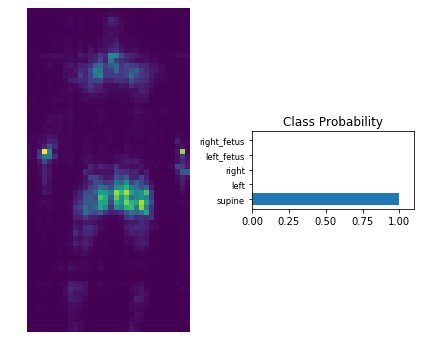

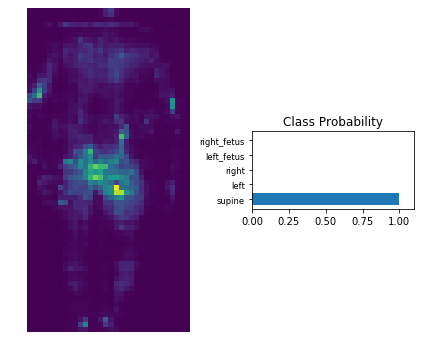

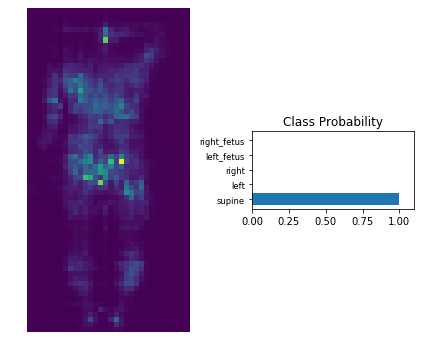

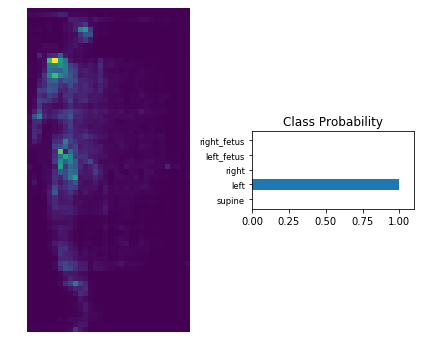

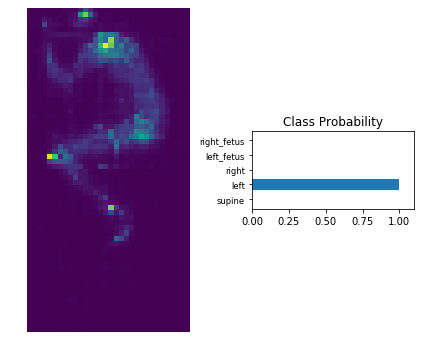

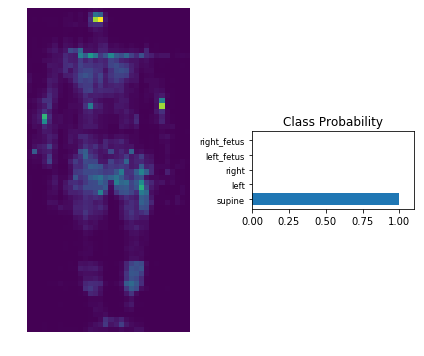

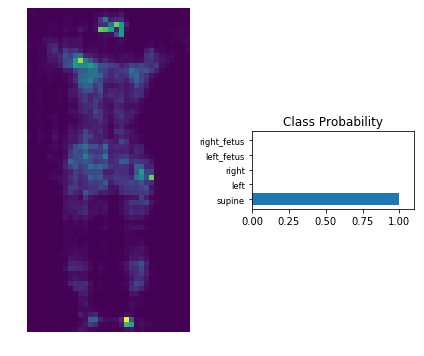

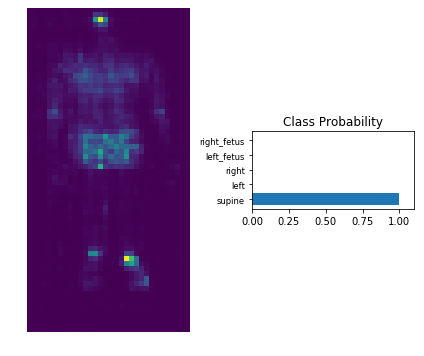

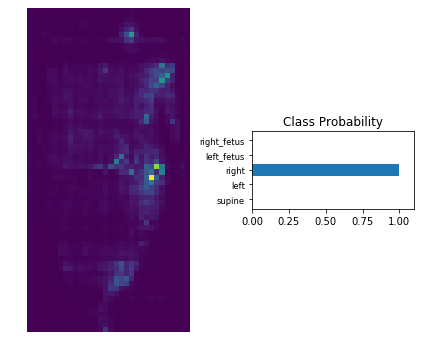

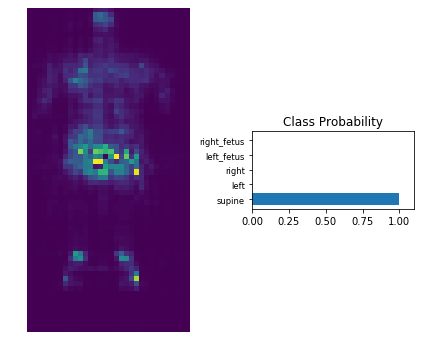

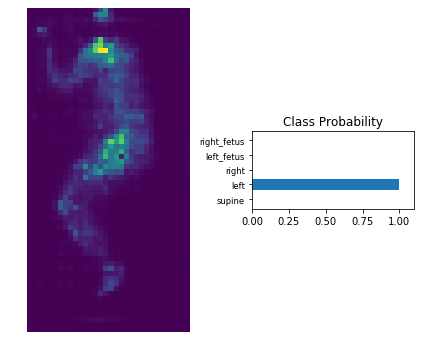

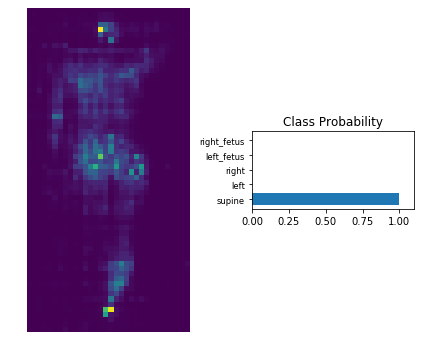

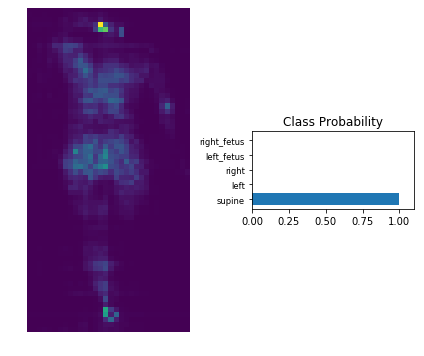

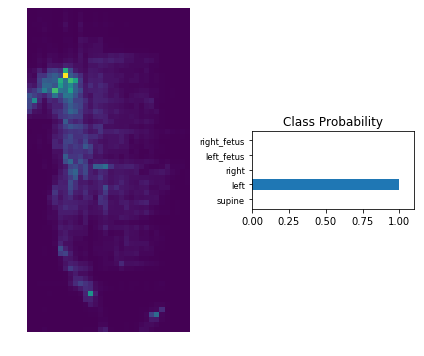

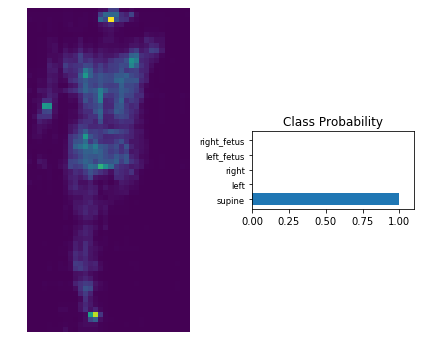

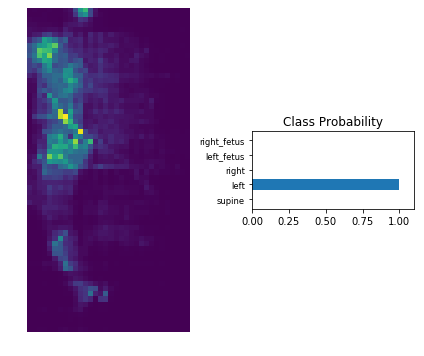

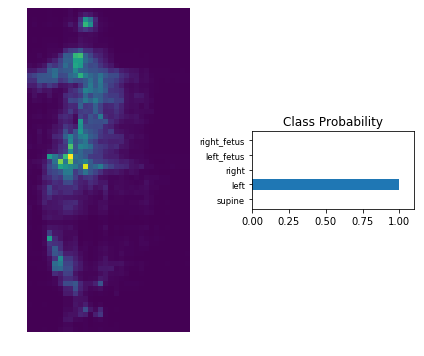

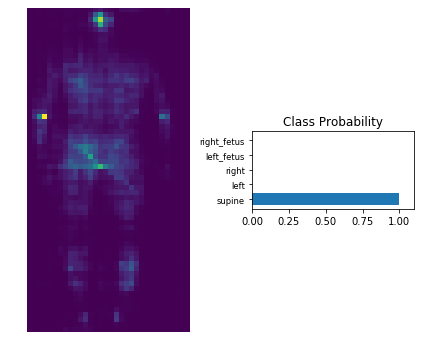

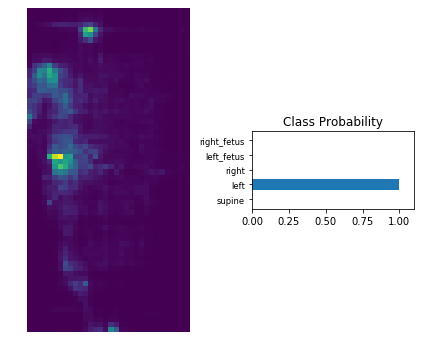

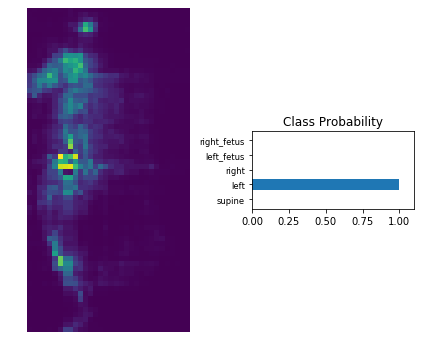

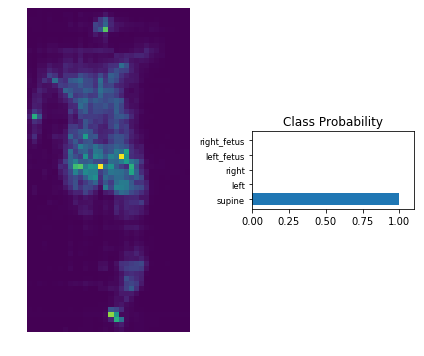

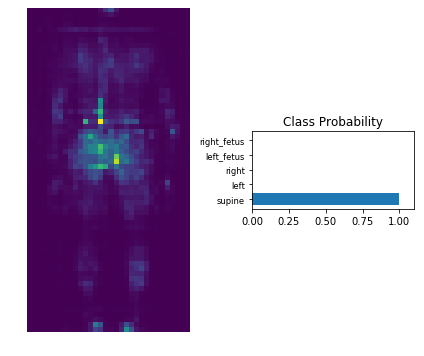

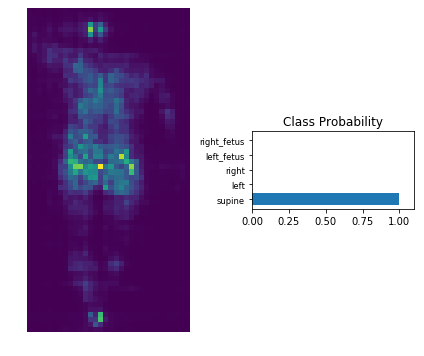

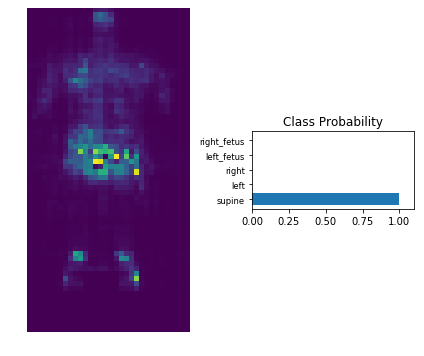

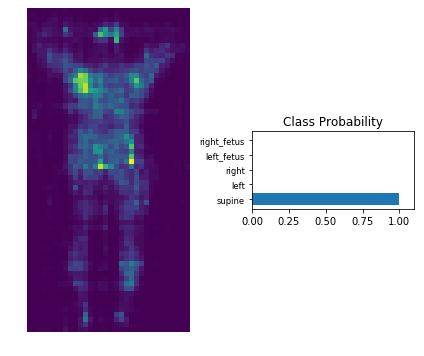

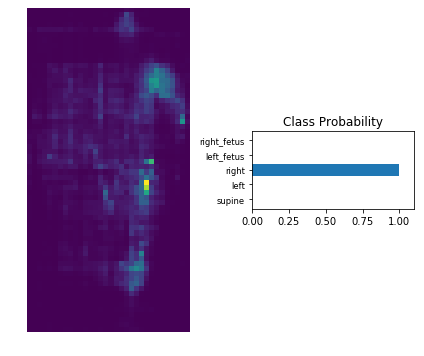

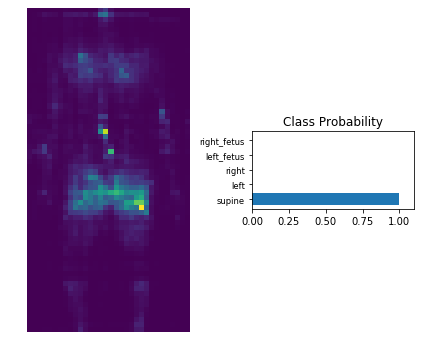

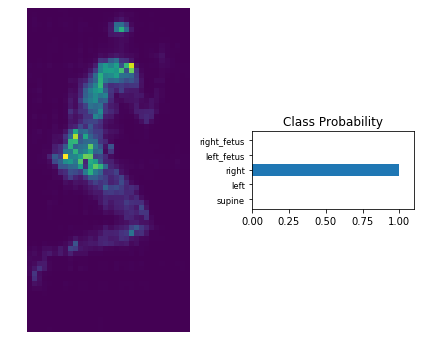

In [12]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 64, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
  
    ax2.set_yticklabels(['supine', 'left', 'right', 'left_fetus', 'right_fetus'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

for inputs, labels in trainloader:
  inputs, labels = inputs.to(device), labels.to(device)
  view_classify(inputs[0].unsqueeze(0).cpu(), torch.exp(model.forward(inputs[0].unsqueeze(0))).cpu())


In [0]:
from torchvision import transforms

trans = transforms.Compose([
    transforms.ToPILImage(),

    #transforms.Resize((70, 32)),
    transforms.ToTensor()
])

myimage = inputs[2].cpu().float()

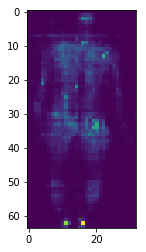

In [14]:
plt.imshow(subjects_dict["S1"][0][1])

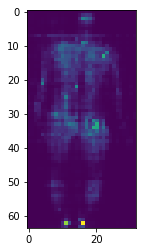

In [15]:
plt.imshow(trans(subjects_dict["S1"][0][1]).view(64,32))

In [16]:
trans(myimage).view(64,32)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
myimage

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

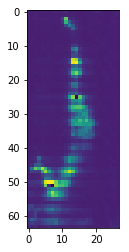

In [58]:
test_read = np.loadtxt("/content/drive/My Drive/Raw_Data/experiment-ii/S3/Air_Mat/Matrix_Air_G2.txt")
test_read = np.round(test_read*255/500).astype(np.uint8)

plt.imshow(test_read)


In [0]:
import torchvision.transforms.functional as TF

trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 32)),
    transforms.ToTensor()
])



In [0]:
totns = transforms.ToTensor()
tnsed=totns(TF.rotate(img=trans(test_read), angle=180))
plt.imshow(tnsed.view(64,32))


In [0]:
tnsed.shape

In [0]:
torch.exp(model.forward(tnsed.view(64,32).unsqueeze(0).cuda()))